# Notebook for plotting and fitting Chd1 binding to nucleosomes

# last updated, 2025 march 12
### for manuscript extended data figure

This script was used to generate data in Nodelman et al., 2025 NSMB. It reads in a single csv file and plots data in different charts.

This script expects to be given folder names that contain csv files. Each csv file should have two comma-separated values per line (no headers), which correspond to the concentration and fraction bound in a titration. The concentration for this experiment is in nM, and the fraction bound is assuming that there are two binding sites (since the nucleosome has 2-fold symmetry). Thus, bands corresponding to a 2:1 species are 100% bound, whereas the 1:1 species is only considered to be 50% bound. 

To run this on your computer, you must give the correct paths/directories for the data and output. These are labeled ###Edit this ### in the block 'Edit this block - define data filename and directories' 

This script was made to run with python 3.8.8 (conda install) and jupyter with the following module versions:

jupyter core     : 4.7.1

jupyter-notebook : 6.3.0

qtconsole        : 5.0.3

ipython          : 7.22.0

ipykernel        : 5.3.4

jupyter client   : 6.1.12

jupyter lab      : 3.0.14

nbconvert        : 6.0.7

ipywidgets       : 7.6.3

nbformat         : 5.1.3

traitlets        : 5.0.5

## preamble

In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
#import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import sys
import time
import statistics
from pylab import *
import re
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import scipy.optimize as opt
from scipy.optimize import curve_fit

matplotlib.rcParams['font.sans-serif']='Arial'
matplotlib.rcParams.update({'font.size': 24, "axes.formatter.limits": (-4,4)})
plotStyles={"markersize":12,"markeredgewidth":3.0,"linewidth":3.0}


colorlist=["red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","yellowgreen","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet","red","orange","green","dodgerblue","darkviolet","gray","brown","orange","chocolate","blue",
          "pink","navajowhite","lightgray","cyan","lightskyblue","mediumpurple","red","olive","brown","green",
           "dodgerblue","darkviolet"
          ]

## equations

In [2]:
def calc_Ka(L,Ka):
    x = (Ka*L)/(1+(Ka*L))
    return x
#L is the chd1 conc
#have to fit for Ka

def calc1_Kd(L,Kd):
    """
    simple function for calculating binding affinity.
    This function assumes fraction bound goes from 0 to 1
    Be sure to include the correct "initial_guess_Kd", with just value,
    when calling this function. L is concentration of Chd1 along x-axis.
    """
    x = (L)/((Kd+L))
    return x
#L is the chd1 conc
#have to fit for Kd

initial_guess_Kd = np.array([100])
initial_guesses2 = np.array([100,1])
initial_guesses3 = np.array([100,1,0.02])

def calc2_Kd(L,Kd,Amp):
    '''
    This fits for Kd, as well as an amplitude (Amp) and constant c
    L is ligand concentration (x-values)
    Be sure to have "guess" include two values needed here
    
    Note that this version of fitting assumes that the baseline is zero, 
    such that at zero ligand L, there is zero binding signal
    '''
    x = (Amp*L)/((Kd+L))
    return x

def calc3_Kd(L,Kd,Amp,c):
    '''
    This fits for Kd, as well as an amplitude (Amp) and constant c
    L is ligand concentration (x-values)
    Be sure to have all three values in the initial_guesses array.
    '''
    x = (Amp*L)/((Kd+L))+c
    return x



def quad10_Kd(P,Kd):
    '''
    This is the explicit (quadratic) fit for Kd. I have hard-coded the
    nucleosome concentration as 10 (nM). P is protein concentration (x-values, [Chd1]).
    '''
    #nucleosome is 10nM
    fractbound=((10+P+Kd)-((10+P+Kd)**2-(4*10*P))**0.5)/(2*10)
    return fractbound

def quad10_Kd_Ampc(P,Kd,Amp,c):
    '''
    This is the explicit (quadratic) fit for Kd. I have hard-coded the
    nucleosome concentration as 10 (nM). P is protein concentration (x-values, [Chd1]).
    Amp is amplitude (near 1.0), c is constant (near zero)
    '''
    #nucleosome is 10nM
    fractbound=(Amp*(10+P+Kd)-((10+P+Kd)**2-(4*10*P))**0.5)/(2*10)+c
    return fractbound

def quad2_Kd_Ampc(P,Kd,Amp,c):
    '''
    This is the explicit (quadratic) fit for Kd. I have hard-coded the
    nucleosome concentration as 2 (nM). P is protein concentration (x-values, [Chd1]).
    Amp is amplitude (near 1.0), c is constant (near zero)
    '''
    #nucleosome is 2nM
    fractbound=(Amp*(2+P+Kd)-((2+P+Kd)**2-(4*2*P))**0.5)/(2*2)+c
    return fractbound

def quad2_Kd_Amp(P,Kd,Amp):
    '''
    This is the explicit (quadratic) fit for Kd. I have hard-coded the
    nucleosome concentration as 2 (nM). P is protein concentration (x-values, [Chd1]).
    Amp is amplitude (near 1.0), c is constant (near zero)
    '''
    #nucleosome is 2nM
    fractbound=(Amp*(2+P+Kd)-((2+P+Kd)**2-(4*2*P))**0.5)/(2*2)
    return fractbound

def quad_Kd_gen(N,P,Kd):
    '''
    This is the explicit (quadratic) fit for Kd. 
    N is nucleosome concentration (nM). P is protein concentration (x-values, [Chd1]).
    In this general form, not clear to me how to feed in both N and P(list).
    '''
    fractbound=((N+P+Kd)-((N+P+Kd)**2-4*N*P)**0.5)/(2*N)
    return fractbound

def calc_Kd_2sitesequiv(L,Kd):
    """
    simple function for calculating binding affinity.
    This function assumes fraction bound goes from 0 to 1
    Be sure to include the correct "initial_guess_Kd", with just value,
    when calling this function.
    """
    fractbound = 0.5*(L)/((Kd+L)) + 0.5*(L)/((Kd+L))
    return fractbound

def calcKddouble_old(L,Kd1,Kd2):
    """
    simple function for calculating binding affinity.
    This function assumes fraction bound goes from 0 to 1
    Be sure to include the correct "initial_guess_Kd", with just value,
    when calling this function.
    """
    fractbound = (0.5*(L)/(Kd1+L)) + (0.5*(L)/(Kd2+L))
    return fractbound

def calcKddouble(L,Kd1,Kd2):
    """
    simple function for calculating binding affinity.
    This function assumes fraction bound goes from 0 to 1
    Be sure to include the correct "initial_guess_Kd", with just value,
    when calling this function.
    """
    fractbound = 0.93*((0.5*(L)/(Kd1+L)) + (0.5*(L)/(Kd2+L)))
    return fractbound

def calcKddoubleAmp(L,Kd1,Kd2,Amp):
    """
    simple function for calculating binding affinity.
    This function assumes fraction bound goes from 0 to 1
    Be sure to include the correct "initial_guess_Kd", with just value,
    when calling this function.
    """
    fractbound = Amp*(0.5*(L)/(Kd1+L) + 0.5*(L)/(Kd2+L))
    return fractbound


## defs

In [3]:
def flatten(l):
    ''' 
    flatten a list of lists, from stack exchange
    https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    '''
    return [item for sublist in l for item in sublist]

def gettimestamp():
    '''
    returns a string of the current day-hour-min
    be sure to import time in preamble
    '''
    if time.localtime().tm_min < 10:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+"0"+str(time.localtime().tm_min)
    else:
        currenttimestamp=str(time.localtime().tm_year)+"_"+str(time.localtime().tm_mon)+"_"+str(time.localtime().tm_mday)+"-"+str(time.localtime().tm_hour)+str(time.localtime().tm_min)
    return(currenttimestamp)


def writelisttofile(tempfilename,templist):
    outputfile=open(tempfilename,"w")
    for line in templist:
        outputfile.write(line)
    outputfile.close()

def extractdatacolumn(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        temp=line.split()
        datalist.append(float(temp[datacolumn]))
    return datalist

def extractdatacolumncsv(tempfilename, datacolumn):
    '''read a file and output a list, here assuming all are floats
    datacolumn input indicates what column to extract
    '''
    #print("###### extractdatacolumncsv ######")
    tempfile=open(tempfilename,"r")
    datalist=[]
    tempfilelist=tempfile.readlines()
    for line in tempfilelist:
        #print(line,"line")
        line.strip()
        if "," in line:
            temp=line.split(",")
            #print(temp)
            for i in range(len(temp)):
                if '\ufeff' in temp[i]:
                    temp[i]=temp[i][1:]
            datalist.append(float(temp[datacolumn]))
    return datalist
    
def datarawstrip(alldatalist, keystart="$DATA", keyend="$ENDDATA", keystartdelay=4):
    '''
    this function strips out all lines that are between key1 and key 2.
    This is helpful for data collected on the Aviv fluorimeter in the biophysics center.
    '''
    newlist=[]
    counter=0
    for line in alldatalist:
        if keystart in line:
            counter=1
            continue
        if keyend in line:
            break
        if counter>0:
            counter+=1
            if counter>keystartdelay:
                newlist.append(line)
    return(newlist)

def makecleancsv(inputfilename):
    '''this will remove weird <U+FEFF> at the start of file, seems to be from excel?
    and output a new csv without this issue'''
    tempfileraw=open(inputfilename,"r")
    tempfile=tempfileraw.readlines()
    for line in tempfile:
        if "\xef\xbb\xbf" in line:
            print(line,YES)
        else:
            print("\tNO - ",line)

def convert1Dlisttoarray(inputlist):
    '''
    this function takes a list as input and returns a numpy array of same length
    this will probably fail if not a list of numbers
    '''
    nplistarray=np.zeros((len(inputlist),))
    for i in range(0,len(inputlist)):
        nplistarray[i]=inputlist[i]
    return(nplistarray)


In [4]:
### create def for plotting? just show plot of one dataset with one fit
# want to also plot the points from the fit on the fit

def plot_datafolders_all(inputdict,dictfolderlist,workingname,parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    parameterdict['update']["figure.figsize"]=12,2*5*len(dictfolderlist)
    print("length of dictfolderlist = {}".format(len(dictfolderlist)))
    print("dictfolderlist = {}".format(dictfolderlist))          
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}

    mpl.rcParams.update(parameterdict['update'])
    print("Using these parameters:")
    for item in parameterdict['update']:
        print(item,parameterdict['update'][item])
    print()
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    fitxvalues=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])

    fig, axs = plt.subplots(2*len(dictfolderlist), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(dictfolderlist)):
        if inputdict[dictfolderlist[i]]["fittingmodel"] == "1site":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                ##axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                axs[i*2].legend()
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddouble":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()
                
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmp":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmpFixed":
            axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i*2+1].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color1"],**parameterdict['plotStyles2'])
            axs[i*2+1].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=inputdict[dictfolderlist[i]]["color1"])
            axs[i*2+1].set_title(inputdict[dictfolderlist[i]]["dataname"]+"-AVG", fontsize=12)
            axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]]["fitAVG"][0],inputdict[dictfolderlist[i]]["fitAVG"][1]),color=inputdict[dictfolderlist[i]]["color1"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i*2].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i*2].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
                #axs[i*2].legend()

    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel='[Chd1] (nM)', ylabel='fraction bound')
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=[1, 5500],ylim=[0.01, 1.1])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return

def plot_datafolders_indiv_together(inputdict,dictfolderlist,workingname,parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    if "figure.figsize" not in parameterdict['update']:
        parameterdict['update']["figure.figsize"]=12,5*len(dictfolderlist)
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}

    mpl.rcParams.update(parameterdict['update'])
    
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    fitxvalues=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])

    fig, axs = plt.subplots(len(dictfolderlist), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(dictfolderlist)):
        if inputdict[dictfolderlist[i]]["fittingmodel"] == "1site":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0]),color=colorlist[j])
                axs[i].legend()
        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddouble":
            #axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i*2].legend()

        elif inputdict[dictfolderlist[i]]["fittingmodel"] == "calcKddoubleAmp":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            for j in inputdict[dictfolderlist[i]]["filekeyindices"]:
                axs[i].plot(inputdict[dictfolderlist[i]][j]["xvalues"], inputdict[dictfolderlist[i]][j]["yvalues"], 'o', label="{}, {}".format(j,inputdict[dictfolderlist[i]][j]["othername"]),color=colorlist[j],**parameterdict['plotStyles1'])
                axs[i].set_title(inputdict[dictfolderlist[i]]["dataname"], fontsize=12)
                axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[dictfolderlist[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[dictfolderlist[i]][j]["fit"][0],inputdict[dictfolderlist[i]][j]["fit"][1]),color=colorlist[j])
                #axs[i*2].legend()

    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel='[Chd1] (nM)', ylabel='fraction bound')
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=[1, 5500],ylim=[0.01, 1.1])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return

def plot_datafolders_indiv_separate(inputdict,dictfolderlist,workingname,parameterdict={}):
    '''
    plot the averages and individual data for the specified folders, along with fits and error bars
    '''

    ### get or set the parameters for the plots
    if 'update' not in parameterdict:
        parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
    if "figure.figsize" not in parameterdict['update']:
        parameterdict['update']["figure.figsize"]=12,5*len(dictfolderlist)
    
    if 'plotStyles1' not in parameterdict:
        parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

    if 'plotStyles2' not in parameterdict:
        parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}
   
    ### here assuming that each folder has a 'xvaluesAVG' list; using largest number for calculating fitting range
    fitxvalues=np.arange(inputdict[dictfolderlist[0]]['xvaluesAVG'][-1])
    
    ### calculate number of subplots...
    subplotmap=[]
    
    for folder in dictfolderlist:
        for expt in inputdict[folder]["filekeyindices"]:
            subplotmap.append([folder,expt])
    
    parameterdict['update']["figure.figsize"]=12,5*len(subplotmap)

    mpl.rcParams.update(parameterdict['update'])

    fig, axs = plt.subplots(len(subplotmap), 1)

    ### note - cannot use i for both the numbering of subfigures and the
    #dirkeyindices
    for i in range(len(subplotmap)):
        if inputdict[subplotmap[i][0]]["fittingmodel"] == "1site":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calc1_Kd(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd ={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0]),color=colorlist[i])
            axs[i].legend()
        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddouble":
            #axs[i*2].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i*2].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddouble(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddoubleAmp":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

        elif inputdict[subplotmap[i][0]]["fittingmodel"] == "calcKddoubleAmpFixed":
            #axs[i].plot(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(inputdict[dictfolderlist[i]]["dataname"]),color=inputdict[dictfolderlist[i]]["color0"],**parameterdict['plotStyles2'])
            #axs[i].errorbar(inputdict[dictfolderlist[i]]["xvaluesAVG"], inputdict[dictfolderlist[i]]["yvaluesAVG"], yerr=inputdict[dictfolderlist[i]]["yvaluesSTDEV"],fmt='o',color=inputdict[dictfolderlist[i]]["color0"])
            axs[i].plot(inputdict[subplotmap[i][0]][subplotmap[i][1]]["xvalues"], inputdict[subplotmap[i][0]][subplotmap[i][1]]["yvalues"], 'o', label="{}, {}".format(subplotmap[i][1],inputdict[subplotmap[i][0]][subplotmap[i][1]]["othername"]),color=colorlist[i],**parameterdict['plotStyles1'])
            axs[i].set_title(inputdict[subplotmap[i][0]]["dataname"], fontsize=12)
            axs[i].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][0],inputdict[subplotmap[i][0]][subplotmap[i][1]]["fit"][1]),color=colorlist[i])
            #axs[i*2].legend()

    ### add this to make it a log plot
    #plt.semilogx()
    ### if a log plot, change the lower bounds for xlim and ylim below
    ##plt.xlim([1, 5500])
    #plt.ylim([0.01, 1.1])

    loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

    for ax in axs.flat:
        ax.semilogx()
        ax.set(xlabel='[Chd1] (nM)', ylabel='fraction bound')
        #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
        ax.set(xlim=[1, 5500],ylim=[0.01, 1.1])
        #ax.xaxis.set_major_locator(loc)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig.tight_layout(h_pad=2)

    #add time stamp to filename
    outputname=workingname+"_"+gettimestamp()+".pdf"

    #uncomment to save plot as a PDF
    fig.savefig(outputname,format='pdf', bbox_inches='tight')
    #fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

    return


# start here

## Edit this block - define data filename and directories

In [5]:
### here, making three levels of dictionaries. The top level is masterdictionary;
###   masterdictionary holds all of the foldernames to be analyzed. 
###
###   In each folder, it is assumed that all data are replicates to be averaged together;
###   So, each folder should be a different condition.
###
###   Within each folder, a new set of dictionaries are created, one for each file in that folder.
###   The key to each of these dictionaries is an integer, corresponding to the order of the files
###   (after sorting alphabetically).
###   Each file is the third level of dictionary, with the keys being common for all:
###   "xvalues", "yvalues", "filename", "othername", "filenumber"
###
###   In the mid-level, each folder will have keys for all of the files (by their index), but also have
###   common keys that correspond to the averages for all data:
###   xvaluesAVG, yvaluesAVG, color1, color2, dataname ==> taken from the directory name, dirname
###

###Edit this ###
outputdirectory="/Users/gbowman3/temp/plots-binding-2025mar12/"
pathtocsvdirectory="/Users/gbowman3/tempdata/binding-csvfiles/"

### create output directory if it doesn't already exist
try:
    os.listdir(outputdirectory)
except FileNotFoundError:
    os.mkdir(outputdirectory)
    print("created new directory for output files:\n{}\n\n".format(outputdirectory))


### Put the path for each directory to be analyzed; for each directory, do not have spaces in the foldername;
###     The data in each folder will automatically be averaged together, so be sure that these datasets go together;
###     Each foldername will be used as the name for that group of files.
###     Put the full path in quotes (a single string), and then a comma to separate each one. 

###Edit this ###
directoriestoanalyze=[
    pathtocsvdirectory+"Chd1-120Bwt-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-120Bwt-ADP-2sites/",
    pathtocsvdirectory+"Chd1-120Bwt-apo-2sites/",
    
    pathtocsvdirectory+"Chd1-SAIL-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-SAIL-ADP-2sites/",
    pathtocsvdirectory+"Chd1-SAIL-apo-2sites/",

    pathtocsvdirectory+"Chd1-SAILLobe2-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-SAILLobe2-ADP-2sites/",
    pathtocsvdirectory+"Chd1-SAILLobe2-apo-2sites/",

    pathtocsvdirectory+"Chd1-876to881-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-876to881-ADP-2sites/",
    pathtocsvdirectory+"Chd1-876to881-apo-2sites/",

    pathtocsvdirectory+"Chd1-884to889-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-884to889-ADP-2sites/",
    pathtocsvdirectory+"Chd1-884to889-apo-2sites/",

    pathtocsvdirectory+"Chd1-890to895-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-890to895-ADP-2sites/",
    pathtocsvdirectory+"Chd1-890to895-apo-2sites/",

    pathtocsvdirectory+"Chd1-896to901-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-896to901-ADP-2sites/",
    pathtocsvdirectory+"Chd1-896to901-apo-2sites/",
    
    pathtocsvdirectory+"Chd1-902to907-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-902to907-ADP-2sites/",
    pathtocsvdirectory+"Chd1-902to907-apo-2sites/",

    #pathtocsvdirectory+"Chd1-901insertion902-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-901insertion902-ADP-2sites/",
    pathtocsvdirectory+"Chd1-901insertion902-apo-2sites/",

    pathtocsvdirectory+"Chd1-L886NL889NL891N-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-L886NL889NL891N-ADP-2sites/",
    pathtocsvdirectory+"Chd1-L886NL889NL891N-apo-2sites/",

    pathtocsvdirectory+"Chd1-Lobe2-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-Lobe2-ADP-2sites/",
    pathtocsvdirectory+"Chd1-Lobe2-apo-2sites/",
    
    pathtocsvdirectory+"Chd1-L865NL869N-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-L865NL869N-ADP-2sites/",
    pathtocsvdirectory+"Chd1-L865NL869N-apo-2sites/",

    pathtocsvdirectory+"Chd1-F917NL918NF921N-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-F917NL918NF921N-ADP-2sites/",
    pathtocsvdirectory+"Chd1-F917NL918NF921N-apo-2sites/",
    
    pathtocsvdirectory+"Chd1-M652Q-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-M652Q-ADP-2sites/",
    pathtocsvdirectory+"Chd1-M652Q-apo-2sites/",

    pathtocsvdirectory+"Chd1-I843N-AMPPNP-2sites/",
    pathtocsvdirectory+"Chd1-I843N-ADP-2sites/",
    pathtocsvdirectory+"Chd1-I843N-apo-2sites/",

    pathtocsvdirectory+"Chd1-W932A-apo-2sites/",
    pathtocsvdirectory+"Chd1-W932A-ADP-2sites/",
    pathtocsvdirectory+"Chd1-W932A-AMPPNP-2sites/"
    
    #pathtocsvdirectory+"40N40plus1-SAIL-ADP/",
    #pathtocsvdirectory+"40N40plus1-SAIL-apo/",
    #pathtocsvdirectory+"40N40plus1-120Bwt-ADP/",
    #pathtocsvdirectory+"40N40plus1-120Bwt-apo/"
 

    #pathtocsvdirectory+"40N40plus1-120Bwt-apo-2sites/"
]



In [6]:
masterdictionary={}
masterdictionary["dirkeys"]=[]

### here give all of the directories to go into

dirkeyindices=[] #list that holds keys for top-level dictionary

for i in range(len(directoriestoanalyze)):
    masterdictionary[i]={}
    masterdictionary[i]["fullpath"]=directoriestoanalyze[i]
    dirsplit=directoriestoanalyze[i].split("/")
    masterdictionary[i]["dataname"]=dirsplit[-2].strip()
    masterdictionary[i]["dirname"]=dirsplit[-2].strip()
    masterdictionary[i]["xyvalues-all"]={} #this will hold all y-values as lists according to x-value
    masterdictionary[i]["xvaluesAVG"]=[] # will fill once read and average together data
    masterdictionary[i]["yvaluesAVG"]=[]
    masterdictionary[i]["yvaluesSTDEV"]=[]
    masterdictionary[i]["fitvalues"]=[]
    masterdictionary[i]["fitAVG"]=[]
    masterdictionary[i]["fitSTDEV"]=[]
    masterdictionary[i]["color0"]="black"
    masterdictionary[i]["color1"]=colorlist[i]
    masterdictionary[i]["color2"]=colorlist[i]
    masterdictionary[i]["filekeyindices"]=[] # this will hold the integers to call individual files
    dirkeyindices.append(i) # these will be in order, so don't need sorting
    #
    ### here record info just based off of information in directory name
    if "apo" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["nucleotide"]="apo"
    elif "ADP" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["nucleotide"]="ADP"
    elif "AMPPNP" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["nucleotide"]="AMPPNP"
    dirnamesplit=masterdictionary[i]["dirname"].split("-")
    if "1site" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="1site"
        masterdictionary[i]["Kdguess"]=np.array([100])
    elif "2sites" in masterdictionary[i]["dataname"]:
        masterdictionary[i]["fittingmodel"]="calcKddouble"
        masterdictionary[i]["Kdguess"]=np.array([50,1000])
    if dirnamesplit[0]=="Chd1":
        masterdictionary[i]["construct"]=dirnamesplit[1]

    # now go into each directory in directoriestoanalyze list and read all files
    
    try:
        alldirectorylisttemp=os.listdir(directoriestoanalyze[i])
        datadirectorylist=[]
        print("reading files in folder:\n\t",directoriestoanalyze[i])
        print()
        print("here only looking at \".csv\" files:")
        for datafile in alldirectorylisttemp:
            if datafile[-3:]=="csv":
                print("\t\t"+datafile)
                datadirectorylist.append(datafile)
        print()
        datadirectorylist.sort()
    except FileNotFoundError:
        print("#"*60,"\n","#"*60)
        print("#"*10,"WARNING: unable to open this directory:","#"*10)
        print("\t{}".format(directoriestoanalyze[i]))
        print("\n")
        print("Please go back and be sure that this directory exists and contains csv files.\n")
        print("#"*60,"\n","#"*60)
        sys.exit("EXITING...")

    ### make a sub-dictionary for each csv file, with the number of the dataset being the key; 
    ### convert string to int; 
    #   xlist and ylist are lists of the first and second items on each line in the file
    #   dataname is the original filename

    print("x-values for each dataset:")
    for j in range(len(datadirectorylist)):
        masterdictionary[i][j]={}
        filename=datadirectorylist[j]
        masterdictionary[i][j]["filename"]=filename
        masterdictionary[i][j]["othername"]=filename
        masterdictionary[i][j]["filenumber"]=j
        masterdictionary[i][j]["xvalues"]=extractdatacolumncsv(directoriestoanalyze[i]+filename,0)
        masterdictionary[i][j]["yvalues"]=extractdatacolumncsv(directoriestoanalyze[i]+filename,1)
        masterdictionary[i]["filekeyindices"].append(int(j))
        if len(masterdictionary[i][j]["xvalues"]) != len(masterdictionary[i][j]["yvalues"]):
            print("#"*60,"\n")
            print("WARNING - the x- and y-values do not match up!")
            print(masterdictionary[i][j]["filename"])
            print(" in folder")
            print(directoriestoanalyze[i])
            print("#"*60,"\n")
            sys.exit()
        print(j, masterdictionary[i][j]["xvalues"])
        for k in range(0,len(masterdictionary[i][j]["xvalues"])):
            if masterdictionary[i][j]["xvalues"][k] in masterdictionary[i]["xyvalues-all"]:
                # key already exists, then just add to the list that should be there
                masterdictionary[i]["xyvalues-all"][masterdictionary[i][j]["xvalues"][k]].append(masterdictionary[i][j]["yvalues"][k])
            else:
                # new key in the dictionary with a 1-item list (the y-value) as the value
                masterdictionary[i]["xyvalues-all"][masterdictionary[i][j]["xvalues"][k]]=[masterdictionary[i][j]["yvalues"][k]]
    #calculate the average y-values for each x-value
    masterdictionary[i]["xvaluesAVG"]=list(masterdictionary[i]["xyvalues-all"].keys())
    print("master xvalues:")
    print("*",masterdictionary[i]["xvaluesAVG"])
    if len(masterdictionary[i]["filekeyindices"])>1:
        for key in masterdictionary[i]["xyvalues-all"].keys():
            masterdictionary[i]["yvaluesAVG"].append(statistics.mean(masterdictionary[i]["xyvalues-all"][key]))
            masterdictionary[i]["yvaluesSTDEV"].append(statistics.stdev(masterdictionary[i]["xyvalues-all"][key]))
    else:
        for key in masterdictionary[i]["xyvalues-all"].keys():
            masterdictionary[i]["yvaluesAVG"].append(masterdictionary[i]["xyvalues-all"][key])
            masterdictionary[i]["yvaluesSTDEV"].append(0)

    print()
print()

print("#"*60,"\n")
print("These folders and datafiles that have been read in:")
for dirnumber in dirkeyindices:
    print(dirnumber,masterdictionary[dirnumber]["dirname"])
    for filenumber in masterdictionary[dirnumber]["filekeyindices"]:
        print("\t",filenumber,masterdictionary[dirnumber][filenumber]["filename"])
    print()
    if len(masterdictionary[dirnumber].keys())<12:
        print("#"*60)
        print("#"*60)
        print("\t WARNING: this directory does not have csv files:")
        print(masterdictionary[dirnumber]["fullpath"])
        print("#"*60)
        print("#"*60)
        print()
        print("Please either put csv files in that directory, or remove from the dir list")
        sys.exit("EXITING...")

masterdictionary["dirkeys"]=list(dirkeyindices)

reading files in folder:
	 /Users/gbowman3/tempdata/binding-csvfiles/Chd1-120Bwt-AMPPNP-2sites/

here only looking at ".csv" files:
		2022May12-Chd1-120B-1ugul-ssDNA-AMPPNP-indiv-2sites.csv
		2022May11-Chd1-120B-1ugul-ssDNA-AMPPNP-ss8604-2sites.csv
		2022May13-Chd1-120B-1ugul-ssDNA-AMPPNP-50mMKCl-2sites.csv
		2022May12-Chd1-120B-1ugul-ssDNA-AMPPNP-MM-2sites.csv
		2022May11-Chd1-120B-1ugul-ssDNA-AMPPNP-ss3844-2sites.csv

x-values for each dataset:
0 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
1 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
2 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
3 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
4 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
master xvalues:
* [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 

1 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
2 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
3 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
master xvalues:
* [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]

reading files in folder:
	 /Users/gbowman3/tempdata/binding-csvfiles/Chd1-L865NL869N-apo-2sites/

here only looking at ".csv" files:
		2023Jan05-Chd1-L865NL869N-1ugul-ssDNA-apo-50mMKCl-2sites.csv
		2022Dec21-Chd1-L865NL869N-1ugul-ssDNA-apo-50mMKCl-2sites.csv
		2023Jan04-Chd1-L865NL869N-1ugul-ssDNA-apo-50mMKCl-2sites.csv
		2022Dec20-Chd1-L865NL869N-1ugul-ssDNA-apo-50mMKCl-2sites.csv

x-values for each dataset:
0 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
1 [2.44, 4.88, 9.77, 19.53125, 39.0625, 78.125, 156.25, 312.5, 625.0, 1250.0, 2500.0, 5000.0]
2 [2.4

In [7]:
#print(masterdictionary[i]["dataname"])
print()
print("Here are the folders loaded in")
print()
for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]["dataname"])
    print()


Here are the folders loaded in

0 Chd1-120Bwt-AMPPNP-2sites

1 Chd1-120Bwt-ADP-2sites

2 Chd1-120Bwt-apo-2sites

3 Chd1-SAIL-AMPPNP-2sites

4 Chd1-SAIL-ADP-2sites

5 Chd1-SAIL-apo-2sites

6 Chd1-SAILLobe2-AMPPNP-2sites

7 Chd1-SAILLobe2-ADP-2sites

8 Chd1-SAILLobe2-apo-2sites

9 Chd1-876to881-AMPPNP-2sites

10 Chd1-876to881-ADP-2sites

11 Chd1-876to881-apo-2sites

12 Chd1-884to889-AMPPNP-2sites

13 Chd1-884to889-ADP-2sites

14 Chd1-884to889-apo-2sites

15 Chd1-890to895-AMPPNP-2sites

16 Chd1-890to895-ADP-2sites

17 Chd1-890to895-apo-2sites

18 Chd1-896to901-AMPPNP-2sites

19 Chd1-896to901-ADP-2sites

20 Chd1-896to901-apo-2sites

21 Chd1-902to907-AMPPNP-2sites

22 Chd1-902to907-ADP-2sites

23 Chd1-902to907-apo-2sites

24 Chd1-901insertion902-ADP-2sites

25 Chd1-901insertion902-apo-2sites

26 Chd1-L886NL889NL891N-AMPPNP-2sites

27 Chd1-L886NL889NL891N-ADP-2sites

28 Chd1-L886NL889NL891N-apo-2sites

29 Chd1-Lobe2-AMPPNP-2sites

30 Chd1-Lobe2-ADP-2sites

31 Chd1-Lobe2-apo-2sites

32 Chd1-

# here modify the "fittingmodel" and "Kdguess" for certain folders
### be sure that these match the correct dataset, as given above

In [8]:
### add other names/parameters for each expt type

### Note: Here, for those plots that clearly had two different Kd values (AMPPNP) but did not saturate,
###       I tried a range of amplitudes and plotted the fits and residuals for different amplitudes 
###       [see bottom of script]. From these tests, the best fit to the shape of the binding curves
###       was to have an amplitude >1.0. Although it is unclear what may be causing this, the better
###       overall fit (and minimal change to the fitted Kd parameters) seems to reasonably justify
###       these higher amplitudes. For others that are far from saturation (ADP and apo), the amplitude
###       was fixed at 0.93. Most of those have Kd values that are >10,000 nM, which are poorly determined
###       no matter what the amplitude. 
###

###Edit this ###

print("Changing parameters for these datasets:")
for i in masterdictionary["dirkeys"]:

    ### first define parameters for the minus1/plus1 nucleosomes
    if "SAIL" in masterdictionary[i]['dataname'] and "ADP" in masterdictionary[i]['dataname'] and "40N40plus1" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.96
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])        
        
    elif "SAIL" in masterdictionary[i]['dataname'] and "apo" in masterdictionary[i]['dataname'] and "40N40plus1" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.90
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])        
     
    elif "SAIL" in masterdictionary[i]['dataname'] and "ADP" in masterdictionary[i]['dataname'] and "40N40minus1" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.99
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])        
    
    ##### these are all for regular 40N40 601 nucleosomes (as well as other +1/-1 nucleosomes, taking defaults)
    
    elif "SAIL" in masterdictionary[i]['dataname'] and "ADP" in masterdictionary[i]['dataname']:        
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])        

    elif "M652Q" in masterdictionary[i]['dataname'] and "ADP" in masterdictionary[i]['dataname']:        
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])        

    elif "ADP" in masterdictionary[i]['dataname']:        
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([1000,10000])  

    elif "apo" in masterdictionary[i]['dataname']:        
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([1000,10000])  
        
    elif "SAILLobe2" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([40,60,0.9])

    elif "SAIL" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([40,60,0.9])

    elif "M652Q" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([40,60,0.9])
        
    elif "884to889" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([50,1000,0.9])

    elif "890to895" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([50,1000,0.9])
        
    elif "L886NL889NL891N" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmp"
        masterdictionary[i]["Kdguess"]=np.array([50,1000,0.9])

    elif "120Bwt" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=0.98
        masterdictionary[i]["Kdguess"]=np.array([50,1000])

    elif "876to881" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=1.13
        masterdictionary[i]["Kdguess"]=np.array([50,1000])

    elif "896to901" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=1.18
        masterdictionary[i]["Kdguess"]=np.array([50,1000])

    elif "902to907" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=1.18
        masterdictionary[i]["Kdguess"]=np.array([50,1000])

    elif "L865NL869N" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=0.95
        masterdictionary[i]["Kdguess"]=np.array([50,1000])

    elif "F917NL918NF921N" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=1.06
        masterdictionary[i]["Kdguess"]=np.array([50,1000])
 
    elif "Lobe2" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=0.87
        masterdictionary[i]["Kdguess"]=np.array([50,1000])
 
    elif "W932A" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["fixedAmpvalue"]=0.99
        masterdictionary[i]["Kdguess"]=np.array([50,3000])

    elif "AMPPNP" in masterdictionary[i]['dataname']:        
        print(masterdictionary[i]['dataname'])
        masterdictionary[i]["fixedAmpvalue"]=0.99
        masterdictionary[i]["fittingmodel"]="calcKddoubleAmpFixed"
        masterdictionary[i]["Kdguess"]=np.array([100,3000])  



Changing parameters for these datasets:
Chd1-120Bwt-AMPPNP-2sites
Chd1-120Bwt-ADP-2sites
Chd1-120Bwt-apo-2sites
Chd1-SAIL-AMPPNP-2sites
Chd1-SAIL-ADP-2sites
Chd1-SAIL-apo-2sites
Chd1-SAILLobe2-AMPPNP-2sites
Chd1-SAILLobe2-ADP-2sites
Chd1-SAILLobe2-apo-2sites
Chd1-876to881-AMPPNP-2sites
Chd1-876to881-ADP-2sites
Chd1-876to881-apo-2sites
Chd1-884to889-AMPPNP-2sites
Chd1-884to889-ADP-2sites
Chd1-884to889-apo-2sites
Chd1-890to895-AMPPNP-2sites
Chd1-890to895-ADP-2sites
Chd1-890to895-apo-2sites
Chd1-896to901-AMPPNP-2sites
Chd1-896to901-ADP-2sites
Chd1-896to901-apo-2sites
Chd1-902to907-AMPPNP-2sites
Chd1-902to907-ADP-2sites
Chd1-902to907-apo-2sites
Chd1-901insertion902-ADP-2sites
Chd1-901insertion902-apo-2sites
Chd1-L886NL889NL891N-AMPPNP-2sites
Chd1-L886NL889NL891N-ADP-2sites
Chd1-L886NL889NL891N-apo-2sites
Chd1-Lobe2-AMPPNP-2sites
Chd1-Lobe2-ADP-2sites
Chd1-Lobe2-apo-2sites
Chd1-L865NL869N-AMPPNP-2sites
Chd1-L865NL869N-ADP-2sites
Chd1-L865NL869N-apo-2sites
Chd1-F917NL918NF921N-AMPPNP-2sites


## calculate fits

In [9]:

for folder in dirkeyindices:
    print("===> ",masterdictionary[folder]["dataname"]," <===")
    print("\tdirectory = {}".format(masterdictionary[folder]["dirname"]))
    for expt in masterdictionary[folder]["filekeyindices"]:
        print("calculating fit for",masterdictionary[folder][expt]["filename"])
        if masterdictionary[folder]["fittingmodel"] == "1site":
            ### note - here fitting with amplitude fixed at 1.0 
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(calc1_Kd,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["Kdguess"])
            print("1-site Kd calculated to be {:9.2f} nM".format(masterdictionary[folder][expt]["fit"][0]))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "calcKddoubleAmp":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(calcKddoubleAmp,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["Kdguess"])
            tempfitlist=masterdictionary[folder][expt]["fit"][0:2]
            tempfitlist.sort()
            masterdictionary[folder][expt]["fit"][0]=tempfitlist[0]
            masterdictionary[folder][expt]["fit"][1]=tempfitlist[1]
            print("2-site Kd, both floating, calculated to be {:9.2f}nM and {:9.2f}nM".format(masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
            print("\tamp calculated to be {:5.3f}".format(masterdictionary[folder][expt]["fit"][2]))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "calcKddoubleAmpFixed":
            ### This is the same as calcKddoubleAmp except that the Amp is being fixed;
            #   the fixed Amp value should be stored in masterdictionary[folder]["fixedAmpvalue"]
            fixedamp = masterdictionary[folder]["fixedAmpvalue"]
            tempfit, tempcovp = curve_fit(lambda L,Kd1,Kd2: calcKddoubleAmp(L,Kd1,Kd2,fixedamp),masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["Kdguess"])
            # make sure that smaller Kd is first
            tempfitlist = list(tempfit[:])
            tempfitlist.sort()            
            ### put the amplitude back with the fit parameters, easier to plot
            masterdictionary[folder][expt]["fit"]=[]
            for value in tempfitlist:
                masterdictionary[folder][expt]["fit"].append(value)
            masterdictionary[folder][expt]["fit"].append(fixedamp)
            masterdictionary[folder][expt]["covp"] = tempcovp
            print("2-site Kd calculated to be {:9.2f}nM and {:9.2f}nM".format(masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
            print("\tfixed amp = {}".format(fixedamp))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "calcKddouble":      
            masterdictionary[folder][expt]["fit"],masterdictionary[folder][expt]["covp"] = \
            curve_fit(calcKddouble,masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["Kdguess"])
            masterdictionary[folder][expt]["fit"].sort()
            print("2-site Kd, both floating, calculated to be {:9.2f}nM and {:9.2f}nM".format(masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
            print()

        elif masterdictionary[folder]["fittingmodel"] == "fitamprange":
            # for these, only have two values for guess (for two Kd values), like
            # ==> masterdictionary[i]["Kdguess"]=np.array([50,1000])
            # Also, expect to have something defined above, like 
            # ==> masterdictionary[i]["fitamprangevalues"]=np.arange(0.89,0.96,0.002)
            print()
            print("===>in fitamprange")
            if "fitamprangevalues" in masterdictionary[folder]:
                masterdictionary[folder][expt]["fitamprange"]={} #make dictionary to hold fitting results
                masterdictionary[folder][expt]["fitamprange"]["kd1list"]=[]
                masterdictionary[folder][expt]["fitamprange"]["kd2list"]=[]
                masterdictionary[folder][expt]["fitamprange"]["residualsumlist"]=[]
                for workingamp in masterdictionary[folder]["fitamprangevalues"]:
                    print("\tamp={}".format(workingamp))
                    masterdictionary[folder][expt]["fitamprange"][workingamp]={} ### make new dictionary to hold info for each amplitude
                    tempfit, tempcovp = curve_fit(lambda L,Kd1,Kd2: calcKddoubleAmp(L,Kd1,Kd2,workingamp),masterdictionary[folder][expt]["xvalues"],masterdictionary[folder][expt]["yvalues"],masterdictionary[folder]["Kdguess"])
                    masterdictionary[folder][expt]["fitamprange"][workingamp]["fit"]=tempfit
                    masterdictionary[folder][expt]["fitamprange"][workingamp]["residuals"]=[]
                    ### now calculate residuals for each amplitude and fit
                    tempsum=0
                    
                    for i in range(len(masterdictionary[folder][expt]["xvalues"])):
                        x = masterdictionary[folder][expt]["xvalues"][i]
                        kd1 = masterdictionary[folder][expt]["fitamprange"][workingamp]["fit"][0]
                        kd2 = masterdictionary[folder][expt]["fitamprange"][workingamp]["fit"][1]
                        ypred = calcKddoubleAmp(x,kd1,kd2,workingamp)
                        ydata = masterdictionary[folder][expt]["yvalues"][i]
                        masterdictionary[folder][expt]["fitamprange"][workingamp]["residuals"].append(ydata-ypred)
                        tempsum=tempsum+math.sqrt((ydata-ypred)**2)
                    masterdictionary[folder][expt]["fitamprange"][workingamp]["residualsum"]=tempsum
                    masterdictionary[folder][expt]["fitamprange"]["residualsumlist"].append(tempsum)
                    masterdictionary[folder][expt]["fitamprange"]["kd1list"].append(kd1)
                    masterdictionary[folder][expt]["fitamprange"]["kd2list"].append(kd2)
                    print("\tfit={}; residuals sum={}".format(tempfit,tempsum))
                    print()
                ### make another for loop here to print the results
                # here loop through and figure out the avg and stdev of kd1, kd2, and residualsum
                masterdictionary[folder][expt]["fitamprange"]["kd1_AVG"]=np.mean(masterdictionary[folder][expt]["fitamprange"]["kd1list"])
                masterdictionary[folder][expt]["fitamprange"]["kd1_STDEV"]=np.std(masterdictionary[folder][expt]["fitamprange"]["kd1list"],ddof=1)
                masterdictionary[folder][expt]["fitamprange"]["kd2_AVG"]=np.mean(masterdictionary[folder][expt]["fitamprange"]["kd2list"])
                masterdictionary[folder][expt]["fitamprange"]["kd2_STDEV"]=np.std(masterdictionary[folder][expt]["fitamprange"]["kd2list"],ddof=1)
                masterdictionary[folder][expt]["fitamprange"]["residualsum_AVG"]=np.mean(masterdictionary[folder][expt]["fitamprange"]["residualsumlist"])
                masterdictionary[folder][expt]["fitamprange"]["residualsum_STDEV"]=np.std(masterdictionary[folder][expt]["fitamprange"]["residualsumlist"],ddof=1)
                print()
                print("for the entire range of amplitudes used here:")
                print("\t{}".format(masterdictionary[folder]["fitamprangevalues"]))
                print("residualsum_STDEV = {}".format(masterdictionary[folder][expt]["fitamprange"]["residualsum_STDEV"]))
                print("\tkd1 = {} +/- {}".format(masterdictionary[folder][expt]["fitamprange"]["kd1_AVG"],masterdictionary[folder][expt]["fitamprange"]["kd1_STDEV"]))
                print("\tkd2 = {} +/- {}".format(masterdictionary[folder][expt]["fitamprange"]["kd2_AVG"],masterdictionary[folder][expt]["fitamprange"]["kd2_STDEV"]))
                print()
            else:
                print("#"*60)
                print("warning: need to set \"fitamprangevalues\" in folder {}".format(folder))
                print("#"*60)
                
            #print("2-site Kd, both floating, calculated to be {:9.2f}nM and {:9.2f}nM".format(masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
            #print()


    firstfileindex=masterdictionary[folder]["filekeyindices"][0]
    # make empty np array - easier to call specific columns 
    if "fit" in masterdictionary[folder][firstfileindex]:
        masterdictionary[folder]["fitvalues"]=np.zeros((len(masterdictionary[folder]["filekeyindices"]),len(masterdictionary[folder][firstfileindex]["fit"])))
    masterdictionary[folder]["fitAVG"]=[]
    masterdictionary[folder]["fitSTDEV"]=[]
    # now loop through again and fill up the np array
    ### comment out for now...
    
    for m in masterdictionary[folder]["filekeyindices"]:
        for n in range(len(masterdictionary[folder][0]["fit"])):
            masterdictionary[folder]["fitvalues"][m][n]=masterdictionary[folder][m]["fit"][n]
    # here calculate mean and stdev for each parameter in the "fit" list; note that fit[0] is the calculated rate
    if len(masterdictionary[folder]["filekeyindices"])>1:
        ### this code below doesn't seem correct - should not use for loop, but just calculate AVG and SD once
        for n in range(len(masterdictionary[folder][firstfileindex]["fit"])):
            masterdictionary[folder]["fitAVG"].append(statistics.mean(masterdictionary[folder]["fitvalues"][:,n]))
            masterdictionary[folder]["fitSTDEV"].append(statistics.stdev(masterdictionary[folder]["fitvalues"][:,n]))
    else:
        for n in range(len(masterdictionary[folder][firstfileindex]["fit"])):
            masterdictionary[folder]["fitAVG"].append(masterdictionary[folder]["fitvalues"][0,n])
            masterdictionary[folder]["fitSTDEV"].append(0)

    if len(masterdictionary[folder]["fitAVG"])>1:
        print("{}: fitAVGs \n\tKd1= {:6.1f} +/-{:5.1f} nM\t Kd2 = {:6.1f} +/-{:6.1f} nM".format(masterdictionary[folder]["dataname"],masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1]))
    else:
        print("{}: fitAVG \n\tKd1= {:6.1f}+/-{:5.1f} nM".format(masterdictionary[folder]["dataname"],masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0]))
    
    print()    
    


===>  Chd1-120Bwt-AMPPNP-2sites  <===
	directory = Chd1-120Bwt-AMPPNP-2sites
calculating fit for 2022May11-Chd1-120B-1ugul-ssDNA-AMPPNP-ss3844-2sites.csv
2-site Kd calculated to be     49.92nM and   8580.89nM
	fixed amp = 0.98

calculating fit for 2022May11-Chd1-120B-1ugul-ssDNA-AMPPNP-ss8604-2sites.csv
2-site Kd calculated to be     47.33nM and   9716.56nM
	fixed amp = 0.98

calculating fit for 2022May12-Chd1-120B-1ugul-ssDNA-AMPPNP-MM-2sites.csv
2-site Kd calculated to be     39.61nM and  10378.27nM
	fixed amp = 0.98

calculating fit for 2022May12-Chd1-120B-1ugul-ssDNA-AMPPNP-indiv-2sites.csv
2-site Kd calculated to be     57.04nM and   8955.98nM
	fixed amp = 0.98

calculating fit for 2022May13-Chd1-120B-1ugul-ssDNA-AMPPNP-50mMKCl-2sites.csv
2-site Kd calculated to be     40.88nM and   9130.93nM
	fixed amp = 0.98

Chd1-120Bwt-AMPPNP-2sites: fitAVGs 
	Kd1=   47.0 +/-  7.1 nM	 Kd2 = 9352.5 +/- 704.7 nM

===>  Chd1-120Bwt-ADP-2sites  <===
	directory = Chd1-120Bwt-ADP-2sites
calculating 

## Plotting all data with fits - indiv datasets for plot 1; AVG for plot 2
### quick visual check for egregious errors/mistakes

In [10]:
#print(masterdictionary[i]["dataname"])
print()
print("Here are the folders loaded in")
print()
for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]["dataname"])
    print()


Here are the folders loaded in

0 Chd1-120Bwt-AMPPNP-2sites

1 Chd1-120Bwt-ADP-2sites

2 Chd1-120Bwt-apo-2sites

3 Chd1-SAIL-AMPPNP-2sites

4 Chd1-SAIL-ADP-2sites

5 Chd1-SAIL-apo-2sites

6 Chd1-SAILLobe2-AMPPNP-2sites

7 Chd1-SAILLobe2-ADP-2sites

8 Chd1-SAILLobe2-apo-2sites

9 Chd1-876to881-AMPPNP-2sites

10 Chd1-876to881-ADP-2sites

11 Chd1-876to881-apo-2sites

12 Chd1-884to889-AMPPNP-2sites

13 Chd1-884to889-ADP-2sites

14 Chd1-884to889-apo-2sites

15 Chd1-890to895-AMPPNP-2sites

16 Chd1-890to895-ADP-2sites

17 Chd1-890to895-apo-2sites

18 Chd1-896to901-AMPPNP-2sites

19 Chd1-896to901-ADP-2sites

20 Chd1-896to901-apo-2sites

21 Chd1-902to907-AMPPNP-2sites

22 Chd1-902to907-ADP-2sites

23 Chd1-902to907-apo-2sites

24 Chd1-901insertion902-ADP-2sites

25 Chd1-901insertion902-apo-2sites

26 Chd1-L886NL889NL891N-AMPPNP-2sites

27 Chd1-L886NL889NL891N-ADP-2sites

28 Chd1-L886NL889NL891N-apo-2sites

29 Chd1-Lobe2-AMPPNP-2sites

30 Chd1-Lobe2-ADP-2sites

31 Chd1-Lobe2-apo-2sites

32 Chd1-

In [10]:
print(outputdirectory)
#outputdirectory="/Users/gbowman3/OneDrive - Johns Hopkins/BowmanLabOneDrive/IlanaGregShared/2022-BridgeStudy/Chd1-titration-data/plots-2023oct22/"
### create output directory if it doesn't already exist
try:
    os.listdir(outputdirectory)
except FileNotFoundError:
    os.mkdir(outputdirectory)
    print("created new directory for output files:\n{}\n\n".format(outputdirectory))


/Users/gbowman3/temp/plots-binding-2025mar12/


## Plotting all data with fits - single experiment with multiple amplitudes
### data and residuals

length of dictfolderlist = 3
dictfolderlist = [9, 10, 11]
Using these parameters:
font.size 10
axes.formatter.limits (-4, 4)
errorbar.capsize 2
figure.figsize (12, 30)



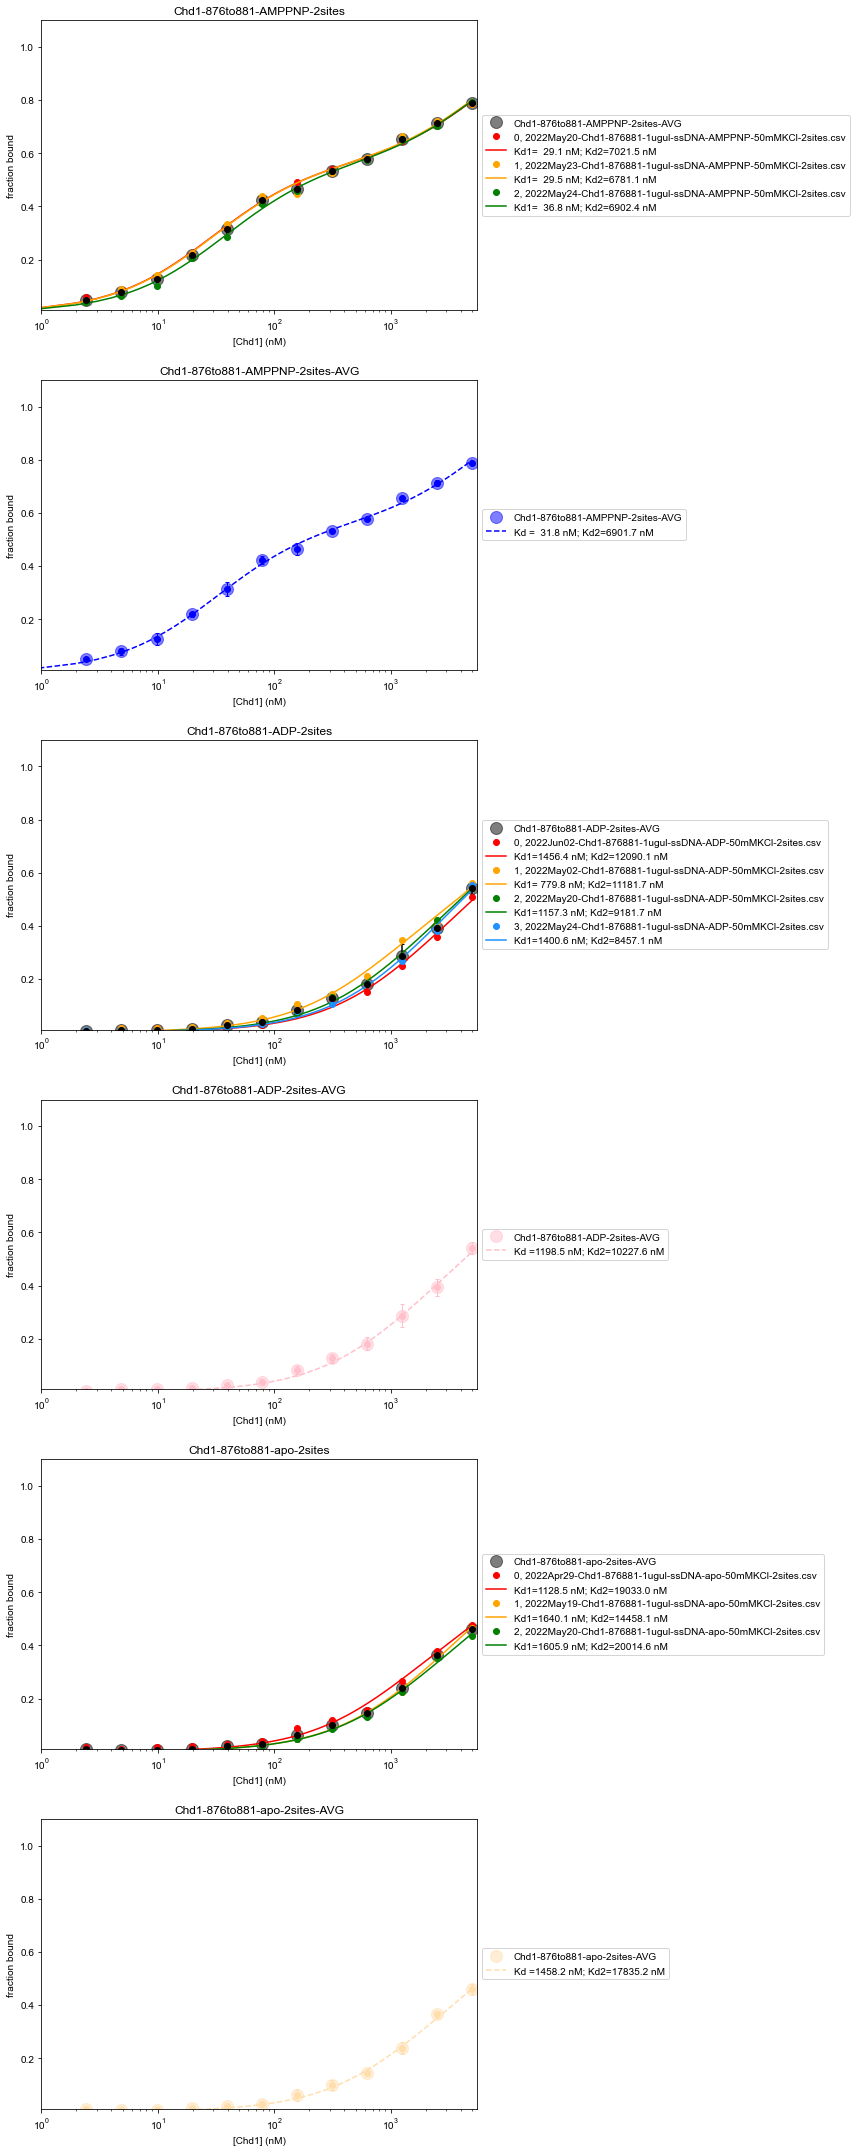

In [11]:
### testing plot_datafolders(inputdict,dictfolderlist,workingname,parameterdict={}):
plotthisfolder=list(range(0,47))
#[1,2,3]
plotthisfolder = [9,10,11]
workingname=outputdirectory+"0-Chd1binding-876881-40N40-"
plot_datafolders_all(masterdictionary,plotthisfolder,workingname)

#plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,listname,listkeys,workingname,parameterdict={}):
#NEW def plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,ampkeylist,workingname):


In [13]:
print(masterdictionary.keys())

dict_keys(['dirkeys', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


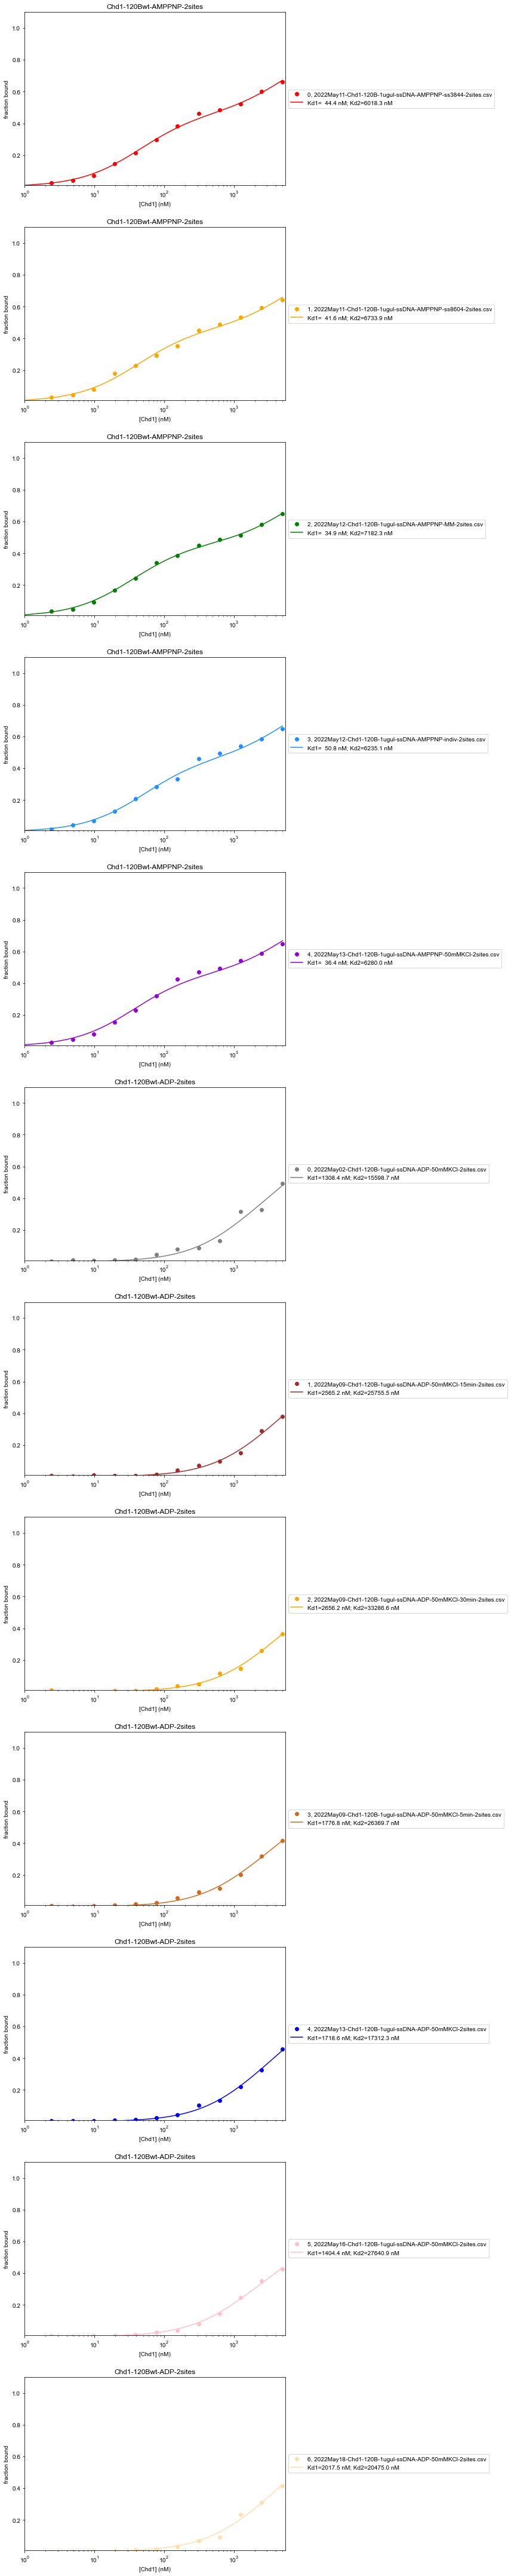

In [13]:
### testing plot_datafolders(inputdict,dictfolderlist,workingname,parameterdict={}):
#def plot_datafolders_indiv_separate(inputdict,dictfolderlist,workingname,parameterdict={}):

plotthesefolders=[0,1]

workingname=outputdirectory+"0-Chd1binding-test-120Bwt-40N40"
plot_datafolders_indiv_separate(masterdictionary,plotthesefolders,workingname)


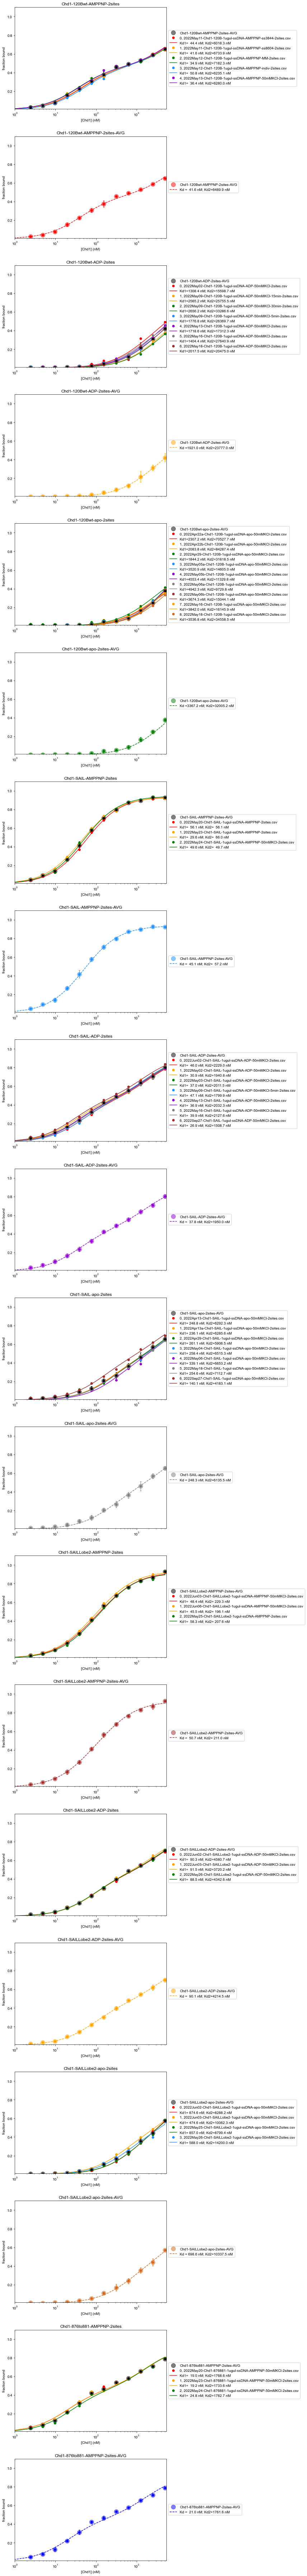

In [11]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 10, "axes.formatter.limits": (-4,4)})

###put which folders you want to plot in "temp"
temp=[0,1,2,3,4,5,6,7,8,9]
mpl.rcParams.update({"figure.figsize": (12,2*5*len(temp)),'errorbar.capsize': 2})

fitxvalues=np.arange(5000)

fig, axs = plt.subplots(2*len(temp), 1)

### note - cannot use i for both the numbering of subfigures and the
#dirkeyindices
for i in range(len(temp)):
    if masterdictionary[temp[i]]["fittingmodel"] == "1site":
        axs[i*2].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color0"],alpha=0.5,markersize=12)
        axs[i*2].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',color=masterdictionary[temp[i]]["color0"])
        axs[i*2+1].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color1"],alpha=0.5,markersize=12)
        axs[i*2+1].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[temp[i]]["color1"])
        axs[i*2+1].set_title(masterdictionary[temp[i]]["dataname"]+"-AVG", fontsize=12)
        axs[i*2+1].plot(fitxvalues, calc1_Kd(fitxvalues, *masterdictionary[temp[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM".format(masterdictionary[temp[i]]["fitAVG"][0]),color=masterdictionary[temp[i]]["color1"])
        for j in masterdictionary[temp[i]]["filekeyindices"]:
            axs[i*2].plot(masterdictionary[temp[i]][j]["xvalues"], masterdictionary[temp[i]][j]["yvalues"], 'o', label="{}, {}".format(j,masterdictionary[temp[i]][j]["othername"]),color=colorlist[j],**plotStyles3)
            axs[i*2].set_title(masterdictionary[temp[i]]["dataname"], fontsize=12)
            axs[i*2].plot(fitxvalues, calc1_Kd(fitxvalues, *masterdictionary[temp[i]][j]["fit"]), '-', label="Kd ={:6.1f} nM".format(masterdictionary[temp[i]][j]["fit"][0]),color=colorlist[j])
            ##axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
            axs[i*2].legend()
    elif masterdictionary[temp[i]]["fittingmodel"] == "calcKddouble":
        axs[i*2].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color0"],alpha=0.5,markersize=12)
        axs[i*2].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',color=masterdictionary[temp[i]]["color0"])
        axs[i*2+1].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color1"],alpha=0.5,markersize=12)
        axs[i*2+1].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[temp[i]]["color1"])
        axs[i*2+1].set_title(masterdictionary[temp[i]]["dataname"]+"-AVG", fontsize=12)
        axs[i*2+1].plot(fitxvalues, calcKddouble(fitxvalues, *masterdictionary[temp[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]]["fitAVG"][0],masterdictionary[temp[i]]["fitAVG"][1]),color=masterdictionary[temp[i]]["color1"])
        for j in masterdictionary[temp[i]]["filekeyindices"]:
            axs[i*2].plot(masterdictionary[temp[i]][j]["xvalues"], masterdictionary[temp[i]][j]["yvalues"], 'o', label="{}, {}".format(j,masterdictionary[temp[i]][j]["othername"]),color=colorlist[j],**plotStyles3)
            axs[i*2].set_title(masterdictionary[temp[i]]["dataname"], fontsize=12)
            axs[i*2].plot(fitxvalues, calcKddouble(fitxvalues, *masterdictionary[temp[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]][j]["fit"][0],masterdictionary[temp[i]][j]["fit"][1]),color=colorlist[j])
            #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
            #axs[i*2].legend()

    elif masterdictionary[temp[i]]["fittingmodel"] == "calcKddoubleAmp":
        axs[i*2].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color0"],alpha=0.5,markersize=12)
        axs[i*2].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',color=masterdictionary[temp[i]]["color0"])
        axs[i*2+1].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color1"],alpha=0.5,markersize=12)
        axs[i*2+1].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[temp[i]]["color1"])
        axs[i*2+1].set_title(masterdictionary[temp[i]]["dataname"]+"-AVG", fontsize=12)
        axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[temp[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]]["fitAVG"][0],masterdictionary[temp[i]]["fitAVG"][1]),color=masterdictionary[temp[i]]["color1"])
        for j in masterdictionary[temp[i]]["filekeyindices"]:
            axs[i*2].plot(masterdictionary[temp[i]][j]["xvalues"], masterdictionary[temp[i]][j]["yvalues"], 'o', label="{}, {}".format(j,masterdictionary[temp[i]][j]["othername"]),color=colorlist[j],**plotStyles3)
            axs[i*2].set_title(masterdictionary[temp[i]]["dataname"], fontsize=12)
            axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[temp[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]][j]["fit"][0],masterdictionary[temp[i]][j]["fit"][1]),color=colorlist[j])
            #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
            #axs[i*2].legend()

    elif masterdictionary[temp[i]]["fittingmodel"] == "calcKddoubleAmpFixed":
        axs[i*2].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color0"],alpha=0.5,markersize=12)
        axs[i*2].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',color=masterdictionary[temp[i]]["color0"])
        axs[i*2+1].plot(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], 'o', label="{}-AVG".format(masterdictionary[temp[i]]["dataname"]),color=masterdictionary[temp[i]]["color1"],alpha=0.5,markersize=12)
        axs[i*2+1].errorbar(masterdictionary[temp[i]]["xvaluesAVG"], masterdictionary[temp[i]]["yvaluesAVG"], yerr=masterdictionary[temp[i]]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[temp[i]]["color1"])
        axs[i*2+1].set_title(masterdictionary[temp[i]]["dataname"]+"-AVG", fontsize=12)
        axs[i*2+1].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[temp[i]]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]]["fitAVG"][0],masterdictionary[temp[i]]["fitAVG"][1]),color=masterdictionary[temp[i]]["color1"])
        for j in masterdictionary[temp[i]]["filekeyindices"]:
            axs[i*2].plot(masterdictionary[temp[i]][j]["xvalues"], masterdictionary[temp[i]][j]["yvalues"], 'o', label="{}, {}".format(j,masterdictionary[temp[i]][j]["othername"]),color=colorlist[j],**plotStyles3)
            axs[i*2].set_title(masterdictionary[temp[i]]["dataname"], fontsize=12)
            axs[i*2].plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[temp[i]][j]["fit"]), '-', label="Kd1={:6.1f} nM; Kd2={:6.1f} nM".format(masterdictionary[temp[i]][j]["fit"][0],masterdictionary[temp[i]][j]["fit"][1]),color=colorlist[j])
            #axs[i,0].plot(fitxvalues, calc2_Kd(fitxvalues, *alldatadict[plotpairs[i][j]]["fitq"]), '--', label="Kd ={:6.1f} nM".format(alldatadict[plotpairs[i][j]]["fitq"][0]),color=colorlist[plotpairs[i][j]])
            #axs[i*2].legend()

### add this to make it a log plot
#plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
##plt.xlim([1, 5500])
#plt.ylim([0.01, 1.1])

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals

for ax in axs.flat:
    ax.semilogx()
    ax.set(xlabel='[Chd1] (nM)', ylabel='fraction bound')
    #ax.set(xlim=[-15, 5000],ylim=[0, 1.1])
    ax.set(xlim=[1, 5500],ylim=[0.01, 1.1])
    #ax.xaxis.set_major_locator(loc)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-differentfittingmodels-120Bwt-40N40-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
#fig.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




In [12]:
for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]['dataname'])

0 Chd1-120Bwt-AMPPNP-2sites
1 Chd1-120Bwt-ADP-2sites
2 Chd1-120Bwt-apo-2sites
3 Chd1-SAIL-AMPPNP-2sites
4 Chd1-SAIL-ADP-2sites
5 Chd1-SAIL-apo-2sites
6 Chd1-SAILLobe2-AMPPNP-2sites
7 Chd1-SAILLobe2-ADP-2sites
8 Chd1-SAILLobe2-apo-2sites
9 Chd1-876to881-AMPPNP-2sites
10 Chd1-876to881-ADP-2sites
11 Chd1-876to881-apo-2sites
12 Chd1-884to889-AMPPNP-2sites
13 Chd1-884to889-ADP-2sites
14 Chd1-884to889-apo-2sites
15 Chd1-890to895-AMPPNP-2sites
16 Chd1-890to895-ADP-2sites
17 Chd1-890to895-apo-2sites
18 Chd1-896to901-AMPPNP-2sites
19 Chd1-896to901-ADP-2sites
20 Chd1-896to901-apo-2sites
21 Chd1-902to907-AMPPNP-2sites
22 Chd1-902to907-ADP-2sites
23 Chd1-902to907-apo-2sites
24 Chd1-901insertion902-ADP-2sites
25 Chd1-901insertion902-apo-2sites
26 Chd1-L886NL889NL891N-AMPPNP-2sites
27 Chd1-L886NL889NL891N-ADP-2sites
28 Chd1-L886NL889NL891N-apo-2sites
29 Chd1-Lobe2-AMPPNP-2sites
30 Chd1-Lobe2-ADP-2sites
31 Chd1-Lobe2-apo-2sites
32 Chd1-L865NL869N-AMPPNP-2sites
33 Chd1-L865NL869N-ADP-2sites
34 Chd1-L8

In [13]:
for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]['dataname'])
    print("fit ",masterdictionary[i]['fitAVG'])
    print()


0 Chd1-120Bwt-AMPPNP-2sites
fit  [46.953491053185815, 9352.526263328295, 0.98]

1 Chd1-120Bwt-ADP-2sites
fit  [1921.026268295167, 23776.95215070193, 0.93]

2 Chd1-120Bwt-apo-2sites
fit  [3367.2075795699184, 32005.20330380684, 0.93]

3 Chd1-SAIL-AMPPNP-2sites
fit  [45.11143156297062, 57.22872329980287, 0.9377087572018973]

4 Chd1-SAIL-ADP-2sites
fit  [37.81112027596783, 1949.980430818989, 0.93]

5 Chd1-SAIL-apo-2sites
fit  [248.31638765555513, 6135.524984380779, 0.93]

6 Chd1-SAILLobe2-AMPPNP-2sites
fit  [50.727277965640646, 210.98677206556619, 0.9259778853458365]

7 Chd1-SAILLobe2-ADP-2sites
fit  [90.09191252530194, 4214.512376725737, 0.93]

8 Chd1-SAILLobe2-apo-2sites
fit  [698.5501030039036, 10337.470573047505, 0.93]

9 Chd1-876to881-AMPPNP-2sites
fit  [31.796443420407968, 6901.6788833204255, 1.13]

10 Chd1-876to881-ADP-2sites
fit  [1198.5291251940762, 10227.647349035322, 0.93]

11 Chd1-876to881-apo-2sites
fit  [1458.1712442876847, 17835.21805849364, 0.93]

12 Chd1-884to889-AMPPNP-2s

### create output CSV file

In [10]:
workingname="Chd1binding-calcKdvalues-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")

### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")

for folder in dirkeyindices:
    if ("dirname" in masterdictionary[folder]):
        myfile.write("data directory,"+masterdictionary[folder]["dirname"]+"\n")
    if ("dataname" in masterdictionary[folder]):
        myfile.write("data name,"+masterdictionary[folder]["dataname"]+"\n")
    if ("fittingmodel" in masterdictionary[folder]):
        myfile.write("fitting model,"+masterdictionary[folder]["fittingmodel"]+"\n")
    if ("notes1" in masterdictionary[folder]): 
        myfile.write("notes,"+masterdictionary[folder]["notes1"]+"\n")
    myfile.write("\n")
    if (masterdictionary[folder]["fittingmodel"]=="1site"):
        myfile.write("index,filename,Kd \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.2f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0]))
            
        myfile.write(",AVG [stdev],{:7.2f},{:7.2f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0]))    
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddouble"):
        myfile.write("index,filename,Kd1,,,Kd2 \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.2f},,,{:7.2f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1]))
        myfile.write(",AVG [stdev],{:7.2f},{:7.2f},,{:7.2f},{:7.2f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1]))  
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddoubleAmp"):
        myfile.write("index,filename,Kd1,,,Kd2,,,Amplitude \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.2f},,,{:7.2f},,,{:7.2f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
        myfile.write(",AVG [stdev],{:7.2f},{:7.2f},,{:7.2f},{:7.2f},,{:7.2f},{:7.2f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2]))  
    elif (masterdictionary[folder]["fittingmodel"]=="calcKddoubleAmpFixed"):
        myfile.write("index,filename,Kd1,,,Kd2,,,Amplitude \n")
        for expt in masterdictionary[folder]["filekeyindices"]:
            myfile.write("{},{},{:7.2f},,,{:7.2f},,,{:7.2f}\n".format(expt,masterdictionary[folder][expt]["filename"],masterdictionary[folder][expt]["fit"][0],masterdictionary[folder][expt]["fit"][1],masterdictionary[folder][expt]["fit"][2]))
        myfile.write(",AVG [stdev],{:7.2f},{:7.2f},,{:7.2f},{:7.2f},,{:7.2f},{:7.2f}\n".format(masterdictionary[folder]["fitAVG"][0],masterdictionary[folder]["fitSTDEV"][0],masterdictionary[folder]["fitAVG"][1],masterdictionary[folder]["fitSTDEV"][1],masterdictionary[folder]["fitAVG"][2],masterdictionary[folder]["fitSTDEV"][2]))  
    myfile.write(",\n")    


myfile.close()

### output raw input data as CSV file

In [13]:
workingname="RawBindingValues-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")

### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")

for folder in dirkeyindices:
    if "AMPPNP" in masterdictionary[folder]["dirname"]:
        myfile.write(masterdictionary[folder]["dirname"]+"\n")
        for expt in masterdictionary[folder]['filekeyindices']:
            myfile.write("Experiment {}\n".format(expt+1))
            myfile.write("concentration (nM), fract bound\n")
            for i in range(len(masterdictionary[folder][expt]['xvalues'])):
                myfile.write("{},{}\n".format(masterdictionary[folder][expt]['xvalues'][i],masterdictionary[folder][expt]['yvalues'][i]))
            myfile.write("\n")
        myfile.write("\n")

myfile.close()

In [18]:
workingname="RawBindingValues-select-apo-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")
plotthese=[0,1,2,
          3,4,5,
          12,13,14,
           38,39,40
          ]
### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")

for folder in plotthese:
    if "apo" in masterdictionary[folder]["dirname"]:
        myfile.write(masterdictionary[folder]["dirname"]+"\n")
        for expt in masterdictionary[folder]['filekeyindices']:
            myfile.write("Experiment {}\n".format(expt+1))
            myfile.write("concentration (nM), fract bound\n")
            for i in range(len(masterdictionary[folder][expt]['xvalues'])):
                myfile.write("{},{}\n".format(masterdictionary[folder][expt]['xvalues'][i],masterdictionary[folder][expt]['yvalues'][i]))
            myfile.write("\n")
        myfile.write("\n")

myfile.close()

### output fraction bound AVG values in CSV file

In [13]:
### here output avg values + SD
workingname="AVGBindingValues-AMPPNPdata-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")
### compare 652 to SAIL, NegC and wt
plotthese=[0,1,2,
          3,4,5,
          12,13,14,
           38,39,40
          ]
### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")

for folder in dirkeyindices:
    #if "dirname" in masterdictionary[folder]:
    if "AMPPNP" in masterdictionary[folder]["dirname"]:
        myfile.write(masterdictionary[folder]["dirname"]+"\n")
        myfile.write("concentration (nM), fract bound, stdev\n")
        for i in range(len(masterdictionary[folder]['xvaluesAVG'])):
            myfile.write("{},{:4.2f},{:5.3f}\n".format(masterdictionary[folder]['xvaluesAVG'][i],masterdictionary[folder]['yvaluesAVG'][i],masterdictionary[folder]['yvaluesSTDEV'][i]))
        myfile.write("\n")

myfile.close()

### output calculated binding values as CSV file

In [23]:
workingname="CalculatedBindingValues-all-"+gettimestamp()+".csv"
myfile=open(outputdirectory+workingname,"w")

### header with basic info
myfile.write("this output file:"+","+workingname+"\n")

myfile.write("date/time,"+gettimestamp()+"\n")

myfile.write("\n")
myfile.write("construct,,,Kd app1 (nM),stdev,,Kd app2 (nM),stdev\n")

for folder in dirkeyindices:
        construct = masterdictionary[folder]["dirname"]
        Kd1 = masterdictionary[folder]['fitAVG'][0]
        Kd2 = masterdictionary[folder]['fitAVG'][1]
        Kd1error = masterdictionary[folder]['fitSTDEV'][0]
        Kd2error = masterdictionary[folder]['fitSTDEV'][1]
        
        myfile.write('{},,,{:7.2f},{:7.2f},,{:7.2f},{:7.2f}\n'.format(construct,Kd1,Kd1error,Kd2,Kd2error))

        myfile.write("\n")

myfile.close()

In [10]:
for i in dirkeyindices:
    print("{} {}".format(i,masterdictionary[i]["dataname"]))

0 Chd1-120Bwt-AMPPNP-2sites
1 Chd1-120Bwt-ADP-2sites
2 Chd1-120Bwt-apo-2sites
3 Chd1-SAIL-AMPPNP-2sites
4 Chd1-SAIL-ADP-2sites
5 Chd1-SAIL-apo-2sites
6 Chd1-SAILLobe2-AMPPNP-2sites
7 Chd1-SAILLobe2-ADP-2sites
8 Chd1-SAILLobe2-apo-2sites
9 Chd1-876to881-AMPPNP-2sites
10 Chd1-876to881-ADP-2sites
11 Chd1-876to881-apo-2sites
12 Chd1-884to889-AMPPNP-2sites
13 Chd1-884to889-ADP-2sites
14 Chd1-884to889-apo-2sites
15 Chd1-890to895-AMPPNP-2sites
16 Chd1-890to895-ADP-2sites
17 Chd1-890to895-apo-2sites
18 Chd1-896to901-AMPPNP-2sites
19 Chd1-896to901-ADP-2sites
20 Chd1-896to901-apo-2sites
21 Chd1-902to907-AMPPNP-2sites
22 Chd1-902to907-ADP-2sites
23 Chd1-902to907-apo-2sites
24 Chd1-901insertion902-ADP-2sites
25 Chd1-901insertion902-apo-2sites
26 Chd1-L886NL889NL891N-AMPPNP-2sites
27 Chd1-L886NL889NL891N-ADP-2sites
28 Chd1-L886NL889NL891N-apo-2sites
29 Chd1-Lobe2-AMPPNP-2sites
30 Chd1-Lobe2-ADP-2sites
31 Chd1-Lobe2-apo-2sites
32 Chd1-L865NL869N-AMPPNP-2sites
33 Chd1-L865NL869N-ADP-2sites
34 Chd1-L8

### change colors for averages

In [26]:
for folder in masterdictionary["dirkeys"]:
    masterdictionary[folder]["color2"]="black"
    masterdictionary[folder]["m1"]="o"
    masterdictionary[folder]["m2"]="o"
    masterdictionary[folder]['markersize']=20
    #mew is marker-edge-width
    masterdictionary[folder]['mew']=2
    masterdictionary[folder]["line"]='-'
        
    if "120Bwt" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dimgray"
        
    elif "SAILLobe2" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
        masterdictionary[folder]["color2"]="lawngreen"
        masterdictionary[folder]['mew']=4

    elif "SAIL" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"

    elif "L865NL869N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"
        masterdictionary[folder]["m1"]="v"
        masterdictionary[folder]["m2"]="v"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'


    elif "876to881" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="forestgreen"

    elif "884to889" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"

    elif "890to895" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="darkorange"

    elif "L886NL889NL891N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'

    elif "896to901" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="gold" 

    elif "902to907" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="khaki"

    elif "901insertion902" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="khaki"
        masterdictionary[folder]["m1"]="P"
        masterdictionary[folder]["m2"]="P"

    elif "Lobe2" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red" 
        masterdictionary[folder]["color2"]="darkorange" 
        masterdictionary[folder]['mew']=4

    elif "F917NL918NF921N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"

    elif "W932A" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"
        masterdictionary[folder]["m1"]="*"
        masterdictionary[folder]["m2"]="*"
        masterdictionary[folder]['markersize']=28
        masterdictionary[folder]["line"]='--'

    elif "M652Q" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
        masterdictionary[folder]["m1"]="X"
        masterdictionary[folder]["m2"]="X"
        masterdictionary[folder]["line"]='--'


    elif "I843N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'
 
    print("{} {} is now {}".format(folder,masterdictionary[folder]["dataname"],masterdictionary[folder]["color1"]))



0 Chd1-120Bwt-AMPPNP-2sites is now dimgray
1 Chd1-120Bwt-ADP-2sites is now dimgray
2 Chd1-120Bwt-apo-2sites is now dimgray
3 Chd1-SAIL-AMPPNP-2sites is now lawngreen
4 Chd1-SAIL-ADP-2sites is now lawngreen
5 Chd1-SAIL-apo-2sites is now lawngreen
6 Chd1-SAILLobe2-AMPPNP-2sites is now red
7 Chd1-SAILLobe2-ADP-2sites is now red
8 Chd1-SAILLobe2-apo-2sites is now red
9 Chd1-876to881-AMPPNP-2sites is now forestgreen
10 Chd1-876to881-ADP-2sites is now forestgreen
11 Chd1-876to881-apo-2sites is now forestgreen
12 Chd1-884to889-AMPPNP-2sites is now red
13 Chd1-884to889-ADP-2sites is now red
14 Chd1-884to889-apo-2sites is now red
15 Chd1-890to895-AMPPNP-2sites is now darkorange
16 Chd1-890to895-ADP-2sites is now darkorange
17 Chd1-890to895-apo-2sites is now darkorange
18 Chd1-896to901-AMPPNP-2sites is now gold
19 Chd1-896to901-ADP-2sites is now gold
20 Chd1-896to901-apo-2sites is now gold
21 Chd1-902to907-AMPPNP-2sites is now khaki
22 Chd1-902to907-ADP-2sites is now khaki
23 Chd1-902to907-apo-2

## Plot data on one graph
### •save a PDF of the graphs by uncommenting the "fig.savefig" command
### •change the "workingname" to give the output a meaningful filename.

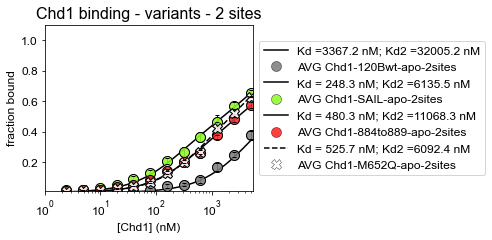

In [24]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 12, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7,3.5),'errorbar.capsize': 2})

fitxvalues=np.arange(5000)

#fig, axs = plt.subplots(2*len(masterdictionary), 1)
###AMPPNP all
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]
###AMPPNP deletions only
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]

nucleotide="apo"
### compare 652 to SAIL, NegC and wt
plotthese=[0,1,2,
          3,4,5,
          12,13,14,
           38,39,40
          ]

#for i in dirkeyindices:
for i in plotthese:
    if nucleotide in masterdictionary[i]['dataname']:
        if "plus1" in masterdictionary[i]["dataname"]:
            plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black")
        else:
            plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), linestyle=masterdictionary[i]["line"], label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black")

        #white transparent background
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]['markersize'])
        # colored symbol
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]['markersize'])
        #black outline
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]['markersize'])
        #error bars
        plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")
        # colored line fit
        

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([1, 5500])
plt.ylim([0.01, 1.1])
plt.legend()
plt.xlabel('[Chd1] (nM)'); 
plt.ylabel('fraction bound'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 binding - variants - 2 sites", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-"+nucleotide+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




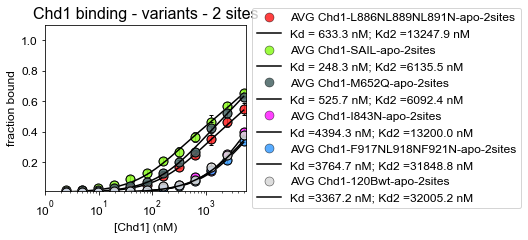

In [30]:
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 12, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (7.5,3.5),'errorbar.capsize': 2})

fitxvalues=np.arange(5000)

#fig, axs = plt.subplots(2*len(masterdictionary), 1)
###AMPPNP all
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]
###AMPPNP deletions only
#plotthese=[0,3,6,9,12,15,18,21,26,29,32,35]

### compare 601 to plus1 for SAIL
plotthese=[26,3,38,41,35,0]
plotthese=[27,4,39,42,36,1]
plotthese=[28,5,40,43,37,2]

#for i in dirkeyindices:
for i in plotthese:
    #error bars
    plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],lw=1,linestyle='None',color="black")

    #white transparent background
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],color="white",linestyle='None',alpha=0.5,markersize=masterdictionary[i]['markersize'])
    # colored symbol
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m1"], mec="black",mew=0.5,linestyle='None',label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=0.75,markersize=masterdictionary[i]['markersize'])
    #black outline
    plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], marker=masterdictionary[i]["m2"],mec="black", mew=1, linestyle='None',fillstyle='none',alpha=1,markersize=masterdictionary[i]['markersize'])
    # colored line fit
    if "plus1" in masterdictionary[i]["dataname"]:
        plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), '--', label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black")
    else:
        plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), '-', label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black")
        

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([1, 5500])
plt.ylim([0.01, 1.1])
plt.legend()
plt.xlabel('[Chd1] (nM)'); 
plt.ylabel('fraction bound'); 

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
plt.title("Chd1 binding - variants - 2 sites", fontsize=16)
legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-apo-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




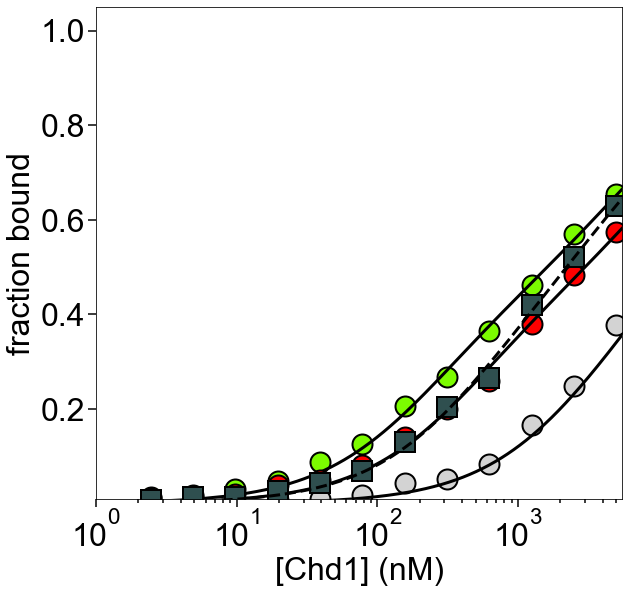

In [18]:
### Updated VERSION
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 32, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (9.5,9),'errorbar.capsize': 2})

fitxvalues=np.arange(6000)

keyword="apo"

plotthese=[0,1,2,
          3,4,5,
          12,13,14,
           38,39,40
          ]
#for i in dirkeyindices:
for i in plotthese:
    if keyword in masterdictionary[i]["dataname"]:
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], masterdictionary[i]["m1"], label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=1,markersize=masterdictionary[i]["markersize"])
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], masterdictionary[i]["m1"],mew=masterdictionary[i]["mew"],markeredgecolor=masterdictionary[i]["color2"],color="none",alpha=1,markersize=masterdictionary[i]["markersize"])
        plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), masterdictionary[i]["line"], label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black",linewidth=3)
    #plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],fmt='o',lw=1,label="{}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"])
    #plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[i]["color1"])

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([1, 5500])
plt.ylim([0.01, 1.05])
#plt.legend()
plt.xlabel('[Chd1] (nM)'); 
plt.ylabel('fraction bound'); 
plt.tick_params(axis='both', which='major', labelsize=32, width=1.5, length=8)
plt.tick_params(axis='both', which='minor', labelsize=32, width=1.5, length=4)

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
#plt.title("Chd1 binding - variants - 2 sites", fontsize=16)
#legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-120Bvariants-"+keyword+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




In [26]:
for folder in masterdictionary["dirkeys"]:
    masterdictionary[folder]["color2"]="black"
    masterdictionary[folder]["m1"]="o"
    masterdictionary[folder]["m2"]="o"
    masterdictionary[folder]['markersize']=20
    #mew is marker-edge-width
    masterdictionary[folder]['mew']=2
    masterdictionary[folder]["line"]='-'
        
    if "120Bwt" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dimgray"
        
    elif "SAILLobe2" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
        masterdictionary[folder]["color2"]="lawngreen"
        masterdictionary[folder]['mew']=4

    elif "SAIL" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"

    elif "L865NL869N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="lawngreen"
        masterdictionary[folder]["m1"]="v"
        masterdictionary[folder]["m2"]="v"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'


    elif "876to881" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="forestgreen"

    elif "884to889" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"

    elif "890to895" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="darkorange"

    elif "L886NL889NL891N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red"
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'

    elif "896to901" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="gold" 

    elif "902to907" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="khaki"

    elif "901insertion902" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="khaki"
        masterdictionary[folder]["m1"]="P"
        masterdictionary[folder]["m2"]="P"

    elif "Lobe2" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="red" 
        masterdictionary[folder]["color2"]="darkorange" 
        masterdictionary[folder]['mew']=4

    elif "F917NL918NF921N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"

    elif "W932A" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="dodgerblue"
        masterdictionary[folder]["m1"]="*"
        masterdictionary[folder]["m2"]="*"
        masterdictionary[folder]['markersize']=28
        masterdictionary[folder]["line"]='--'

    elif "M652Q" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
        masterdictionary[folder]["m1"]="X"
        masterdictionary[folder]["m2"]="X"
        masterdictionary[folder]["line"]='--'


    elif "I843N" in masterdictionary[folder]["dataname"]:
        masterdictionary[folder]["color1"]="white"
        masterdictionary[folder]["m1"]="^"
        masterdictionary[folder]["m2"]="^"
        masterdictionary[folder]['markersize']=22
        masterdictionary[folder]["line"]='--'
 
    print("{} {} is now {}".format(folder,masterdictionary[folder]["dataname"],masterdictionary[folder]["color1"]))



0 Chd1-120Bwt-AMPPNP-2sites is now dimgray
1 Chd1-120Bwt-ADP-2sites is now dimgray
2 Chd1-120Bwt-apo-2sites is now dimgray
3 Chd1-SAIL-AMPPNP-2sites is now lawngreen
4 Chd1-SAIL-ADP-2sites is now lawngreen
5 Chd1-SAIL-apo-2sites is now lawngreen
6 Chd1-SAILLobe2-AMPPNP-2sites is now red
7 Chd1-SAILLobe2-ADP-2sites is now red
8 Chd1-SAILLobe2-apo-2sites is now red
9 Chd1-876to881-AMPPNP-2sites is now forestgreen
10 Chd1-876to881-ADP-2sites is now forestgreen
11 Chd1-876to881-apo-2sites is now forestgreen
12 Chd1-884to889-AMPPNP-2sites is now red
13 Chd1-884to889-ADP-2sites is now red
14 Chd1-884to889-apo-2sites is now red
15 Chd1-890to895-AMPPNP-2sites is now darkorange
16 Chd1-890to895-ADP-2sites is now darkorange
17 Chd1-890to895-apo-2sites is now darkorange
18 Chd1-896to901-AMPPNP-2sites is now gold
19 Chd1-896to901-ADP-2sites is now gold
20 Chd1-896to901-apo-2sites is now gold
21 Chd1-902to907-AMPPNP-2sites is now khaki
22 Chd1-902to907-ADP-2sites is now khaki
23 Chd1-902to907-apo-2

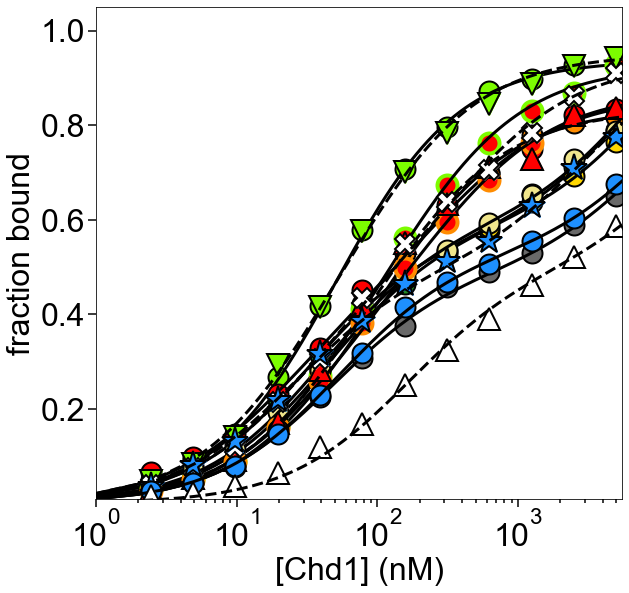

In [32]:
### Updated VERSION
# Based on the index of each experiment given above, show whichever ones you want by giving the index of
# each in the "plotpairs" list of lists

# if you change the number of pairs plotted, also change the "mpl.rcParams.update({"figure.figsize": (7,7)})" below

plotStyles3={"markersize":3,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 32, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (9.5,9),'errorbar.capsize': 2})

fitxvalues=np.arange(6000)

keyword="AMPPNP"

plotthese=[
          3,4,5,
          9,10,11,
          12,13,14,
          15,16,17,
          6,7,8,
           18,19,20,
           21,22,23,
           24,25,
           29,30,31,
           32,33,34,
           
           #38,39,40,#M652Q
           0,1,2,
           26,27,28,
           38,39,40,
           44,45,46,
           35,36,37,
           41,42,43
          ]
#for i in dirkeyindices:
for i in plotthese:
    if keyword in masterdictionary[i]["dataname"]:
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], masterdictionary[i]["m1"], label="AVG {}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"],alpha=1,markersize=masterdictionary[i]["markersize"])
        plt.plot(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], masterdictionary[i]["m1"],mew=masterdictionary[i]["mew"],markeredgecolor=masterdictionary[i]["color2"],color="none",alpha=1,markersize=masterdictionary[i]["markersize"])
        plt.plot(fitxvalues, calcKddoubleAmp(fitxvalues, *masterdictionary[i]["fitAVG"]), masterdictionary[i]["line"], label="Kd ={:6.1f} nM; Kd2 ={:6.1f} nM".format(masterdictionary[i]["fitAVG"][0],masterdictionary[i]["fitAVG"][1]),color="black",linewidth=3)
    #plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],fmt='o',lw=1,label="{}".format(masterdictionary[i]["dataname"]),color=masterdictionary[i]["color1"])
    #plt.errorbar(masterdictionary[i]["xvaluesAVG"], masterdictionary[i]["yvaluesAVG"], yerr=masterdictionary[i]["yvaluesSTDEV"],fmt='o',lw=1,color=masterdictionary[i]["color1"])

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
plt.xlim([1, 5500])
plt.ylim([0.01, 1.05])
#plt.legend()
plt.xlabel('[Chd1] (nM)'); 
plt.ylabel('fraction bound'); 
plt.tick_params(axis='both', which='major', labelsize=32, width=1.5, length=8)
plt.tick_params(axis='both', which='minor', labelsize=32, width=1.5, length=4)

loc = ticker.MultipleLocator(base=1000.0) # this locator puts ticks at regular intervals
#plt.title("Chd1 binding - variants - 2 sites", fontsize=16)
#legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(h_pad=2)   
#fig.tight_layout(h_pad=2)

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-120Bvariants-"+"-"+keyword+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




## Plot Kd values on one graph
### •save a PDF of the graphs by uncommenting the "fig.savefig" command
### •change the "workingname" to give the output a meaningful filename.

In [95]:
print(masterdictionary[20]["fitAVG"])
print(masterdictionary[20]["fitSTDEV"])

[1846.6584312263035, 28234.994542800465, 0.93]
[419.37800695634826, 29958.125195626515, 0.0]


In [18]:
for i in dirkeyindices:
    print("{} {}".format(i,masterdictionary[i]["dataname"]))

0 Chd1-120Bwt-AMPPNP-2sites
1 Chd1-120Bwt-ADP-2sites
2 Chd1-120Bwt-apo-2sites
3 Chd1-SAIL-AMPPNP-2sites
4 Chd1-SAIL-ADP-2sites
5 Chd1-SAIL-apo-2sites
6 Chd1-SAILLobe2-AMPPNP-2sites
7 Chd1-SAILLobe2-ADP-2sites
8 Chd1-SAILLobe2-apo-2sites
9 Chd1-876to881-AMPPNP-2sites
10 Chd1-876to881-ADP-2sites
11 Chd1-876to881-apo-2sites
12 Chd1-884to889-AMPPNP-2sites
13 Chd1-884to889-ADP-2sites
14 Chd1-884to889-apo-2sites
15 Chd1-890to895-AMPPNP-2sites
16 Chd1-890to895-ADP-2sites
17 Chd1-890to895-apo-2sites
18 Chd1-896to901-AMPPNP-2sites
19 Chd1-896to901-ADP-2sites
20 Chd1-896to901-apo-2sites
21 Chd1-902to907-AMPPNP-2sites
22 Chd1-902to907-ADP-2sites
23 Chd1-902to907-apo-2sites
24 Chd1-901insertion902-ADP-2sites
25 Chd1-901insertion902-apo-2sites
26 Chd1-L886NL889NL891N-AMPPNP-2sites
27 Chd1-L886NL889NL891N-ADP-2sites
28 Chd1-L886NL889NL891N-apo-2sites
29 Chd1-Lobe2-AMPPNP-2sites
30 Chd1-Lobe2-ADP-2sites
31 Chd1-Lobe2-apo-2sites
32 Chd1-L865NL869N-AMPPNP-2sites
33 Chd1-L865NL869N-ADP-2sites
34 Chd1-L8

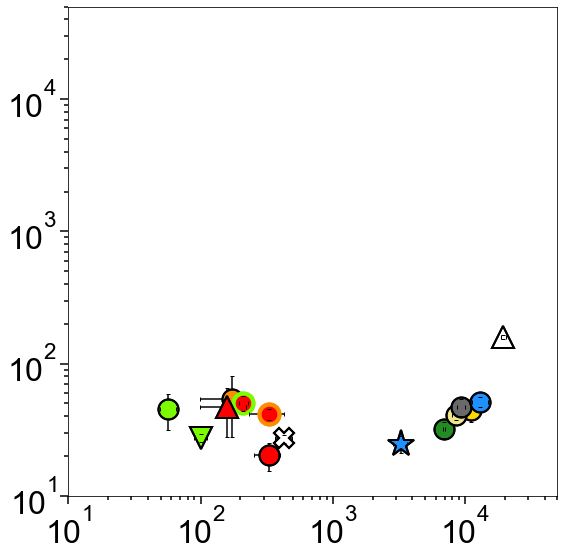

In [33]:
### here just plot average values
plotStyles3={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 32, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (9,9),'errorbar.capsize': 2})

keyword="AMPPNP"

plotthese=list(range(0,43))
plotthese=[
          3,4,5,
          9,10,11,
          12,13,14,
          15,16,17,
          6,7,8,
           18,19,20,
           21,22,23,
           24,25,
           29,30,31,
           32,33,34,
           
           38,39,40,#M652Q
           0,1,2,
           26,27,28,
           
           44,45,46,
           35,36,37,
           41,42,43
          ]
for folder in plotthese:
    if keyword=="AMPPNP":
        if "AMPPNP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="ADP":
        if "ADP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="apo":
        if "apo" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])

### add this to make it a log plot
plt.loglog()
#plt.axis('equal')
plt.axis('square')
plt.xlim([10, 50000])
plt.ylim([10, 50000])
plt.tick_params(axis='both', which='major', labelsize=32, width=1.5, length=8)
plt.tick_params(axis='both', which='minor', labelsize=32, width=1.5, length=4)

#plt.legend()
#legend(loc='center left', bbox_to_anchor=(1, 0.5))

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-2Dploterror-120Bvariants-noM652Q-"+keyword+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')



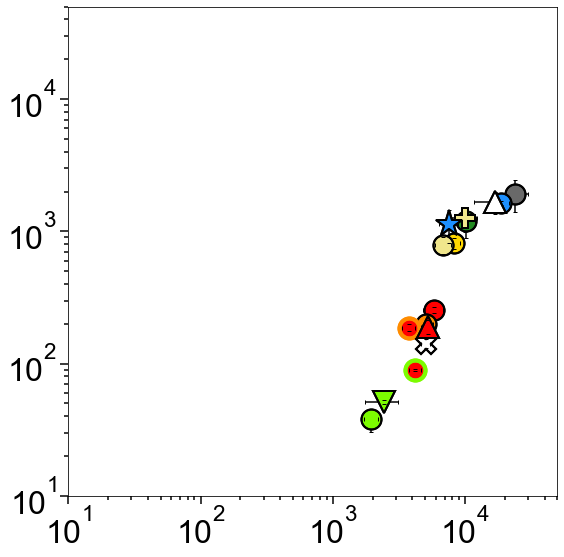

In [34]:
### here just plot average values
plotStyles3={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 32, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (9,9),'errorbar.capsize': 2})

keyword="ADP"

plotthese=list(range(0,43))
plotthese=[
          3,4,5,
          9,10,11,
          12,13,14,
          15,16,17,
          6,7,8,
           18,19,20,
           21,22,23,
           24,25,
           29,30,31,
           32,33,34,
           
           38,39,40,#M652Q
           0,1,2,
           26,27,28,
           
           44,45,46,
           35,36,37,
           41,42,43
          ]
for folder in plotthese:
    if keyword=="AMPPNP":
        if "AMPPNP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="ADP":
        if "ADP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="apo":
        if "apo" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])

### add this to make it a log plot
plt.loglog()
#plt.axis('equal')
plt.axis('square')
plt.xlim([10, 50000])
plt.ylim([10, 50000])
plt.tick_params(axis='both', which='major', labelsize=32, width=1.5, length=8)
plt.tick_params(axis='both', which='minor', labelsize=32, width=1.5, length=4)

#plt.legend()
#legend(loc='center left', bbox_to_anchor=(1, 0.5))

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-2Dploterror-120Bvariants-noM652Q-"+keyword+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')



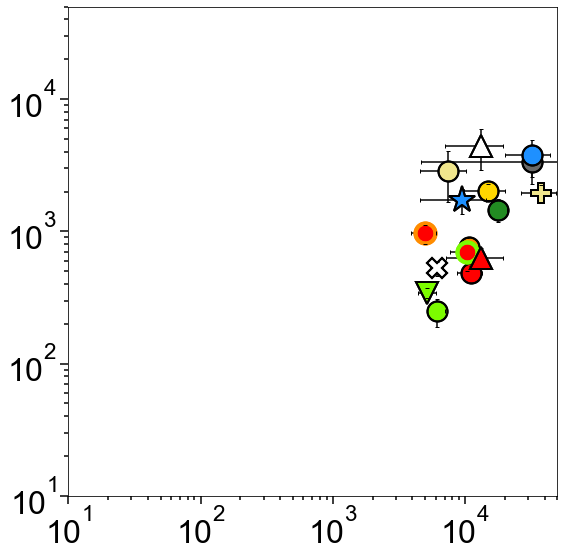

In [35]:
### here just plot average values
plotStyles3={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}
mpl.rcParams.update({'font.size': 32, "axes.formatter.limits": (-4,4)})
mpl.rcParams.update({"figure.figsize": (9,9),'errorbar.capsize': 2})

keyword="apo"

plotthese=list(range(0,43))
plotthese=[
          3,4,5,
          9,10,11,
          12,13,14,
          15,16,17,
          6,7,8,
           18,19,20,
           21,22,23,
           24,25,
           29,30,31,
           32,33,34,
           
           38,39,40,#M652Q
           0,1,2,
           26,27,28,
           
           44,45,46,
           35,36,37,
           41,42,43
          ]
for folder in plotthese:
    if keyword=="AMPPNP":
        if "AMPPNP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="ADP":
        if "ADP" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])
    if keyword=="apo":
        if "apo" in masterdictionary[folder]["dataname"]:
            #mew is marker-edge-width
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m1"], label="AVG {}".format(masterdictionary[folder]["dataname"]), mew=masterdictionary[folder]["mew"],mec=masterdictionary[folder]["color2"],mfc=masterdictionary[folder]["color1"],alpha=1,markersize=masterdictionary[folder]["markersize"])
            plt.plot(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], marker=masterdictionary[folder]["m2"], mec=masterdictionary[folder]["color2"],fillstyle='none',alpha=1,markersize=masterdictionary[folder]["markersize"], mew=masterdictionary[folder]["mew"])
            plt.errorbar(masterdictionary[folder]["fitAVG"][1], masterdictionary[folder]["fitAVG"][0], xerr=masterdictionary[folder]["fitSTDEV"][1],yerr=masterdictionary[folder]["fitSTDEV"][0],color="black",alpha=1.0,markersize=masterdictionary[folder]["markersize"])

### add this to make it a log plot
plt.loglog()
#plt.axis('equal')
plt.axis('square')
plt.xlim([10, 50000])
plt.ylim([10, 50000])
plt.tick_params(axis='both', which='major', labelsize=32, width=1.5, length=8)
plt.tick_params(axis='both', which='minor', labelsize=32, width=1.5, length=4)

#plt.legend()
#legend(loc='center left', bbox_to_anchor=(1, 0.5))

#add time stamp to filename
workingname=outputdirectory+"Chd1binding-2Dploterror-120Bvariants-noM652Q-"+keyword+"-"+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
plt.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')



# Testing fitamprange

### after running this first block, go back and recalculate the fits in the section called
### "calculate fits", then plot in the subsequent block below  

In [51]:
### here doing some fine-tuning of the amplitudes for the AMPPNP datasets 
#      several are fitting poorly with the fixed amplitude of 0.93, so going to see if there is a better
#      number for those with more shape (of 2 separate Kds)


for i in masterdictionary["dirkeys"]:
    print(i,masterdictionary[i]['dataname'])
    
    if "902to907" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:        
        print("\tmodifying fitting model for {}".format(masterdictionary[i]['dataname']))
        #masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="fitamprange"
        masterdictionary[i]["fitamprangevalues"]=np.arange(0.80,1.21,0.01)
        masterdictionary[i]["Kdguess"]=np.array([300,3000])        

    elif "876to881" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:        
        print("\tmodifying fitting model for {}".format(masterdictionary[i]['dataname']))
        #masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="fitamprange"
        masterdictionary[i]["fitamprangevalues"]=np.arange(0.80,1.21,0.01)
        masterdictionary[i]["Kdguess"]=np.array([300,3000])        

    elif "896to901" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:        
        print("\tmodifying fitting model for {}".format(masterdictionary[i]['dataname']))
        #masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="fitamprange"
        masterdictionary[i]["fitamprangevalues"]=np.arange(0.80,1.21,0.01)
        masterdictionary[i]["Kdguess"]=np.array([300,3000])        

    elif "Chd1wt" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:        
        print("\tmodifying fitting model for {}".format(masterdictionary[i]['dataname']))
        #masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="fitamprange"
        masterdictionary[i]["fitamprangevalues"]=np.arange(0.80,1.21,0.01)
        masterdictionary[i]["Kdguess"]=np.array([300,3000])        

    elif "120Bwt" in masterdictionary[i]['dataname'] and "AMPPNP" in masterdictionary[i]['dataname']:        
        print("\tmodifying fitting model for {}".format(masterdictionary[i]['dataname']))
        #masterdictionary[i]["fixedAmpvalue"]=0.93
        masterdictionary[i]["fittingmodel"]="fitamprange"
        masterdictionary[i]["fitamprangevalues"]=np.arange(0.80,1.21,0.01)
        masterdictionary[i]["Kdguess"]=np.array([300,3000])        


0 Chd1-120Bwt-AMPPNP-2sites
	modifying fitting model for Chd1-120Bwt-AMPPNP-2sites
1 Chd1-120Bwt-ADP-2sites
2 Chd1-120Bwt-apo-2sites
3 Chd1-SAIL-AMPPNP-2sites
4 Chd1-SAIL-ADP-2sites
5 Chd1-SAIL-apo-2sites
6 Chd1-SAILLobe2-AMPPNP-2sites
7 Chd1-SAILLobe2-ADP-2sites
8 Chd1-SAILLobe2-apo-2sites
9 Chd1-876to881-AMPPNP-2sites
	modifying fitting model for Chd1-876to881-AMPPNP-2sites
10 Chd1-876to881-ADP-2sites
11 Chd1-876to881-apo-2sites
12 Chd1-884to889-AMPPNP-2sites
13 Chd1-884to889-ADP-2sites
14 Chd1-884to889-apo-2sites
15 Chd1-890to895-AMPPNP-2sites
16 Chd1-890to895-ADP-2sites
17 Chd1-890to895-apo-2sites
18 Chd1-896to901-AMPPNP-2sites
	modifying fitting model for Chd1-896to901-AMPPNP-2sites
19 Chd1-896to901-ADP-2sites
20 Chd1-896to901-apo-2sites
21 Chd1-902to907-AMPPNP-2sites
	modifying fitting model for Chd1-902to907-AMPPNP-2sites
22 Chd1-902to907-ADP-2sites
23 Chd1-902to907-apo-2sites
24 Chd1-901insertion902-ADP-2sites
25 Chd1-901insertion902-apo-2sites
26 Chd1-L886NL889NL891N-AMPPNP-2s

no, fixedamp not in list
no, fixedamp not in list
no, fixedamp not in list
no, fixedamp not in list
no, fixedamp not in list


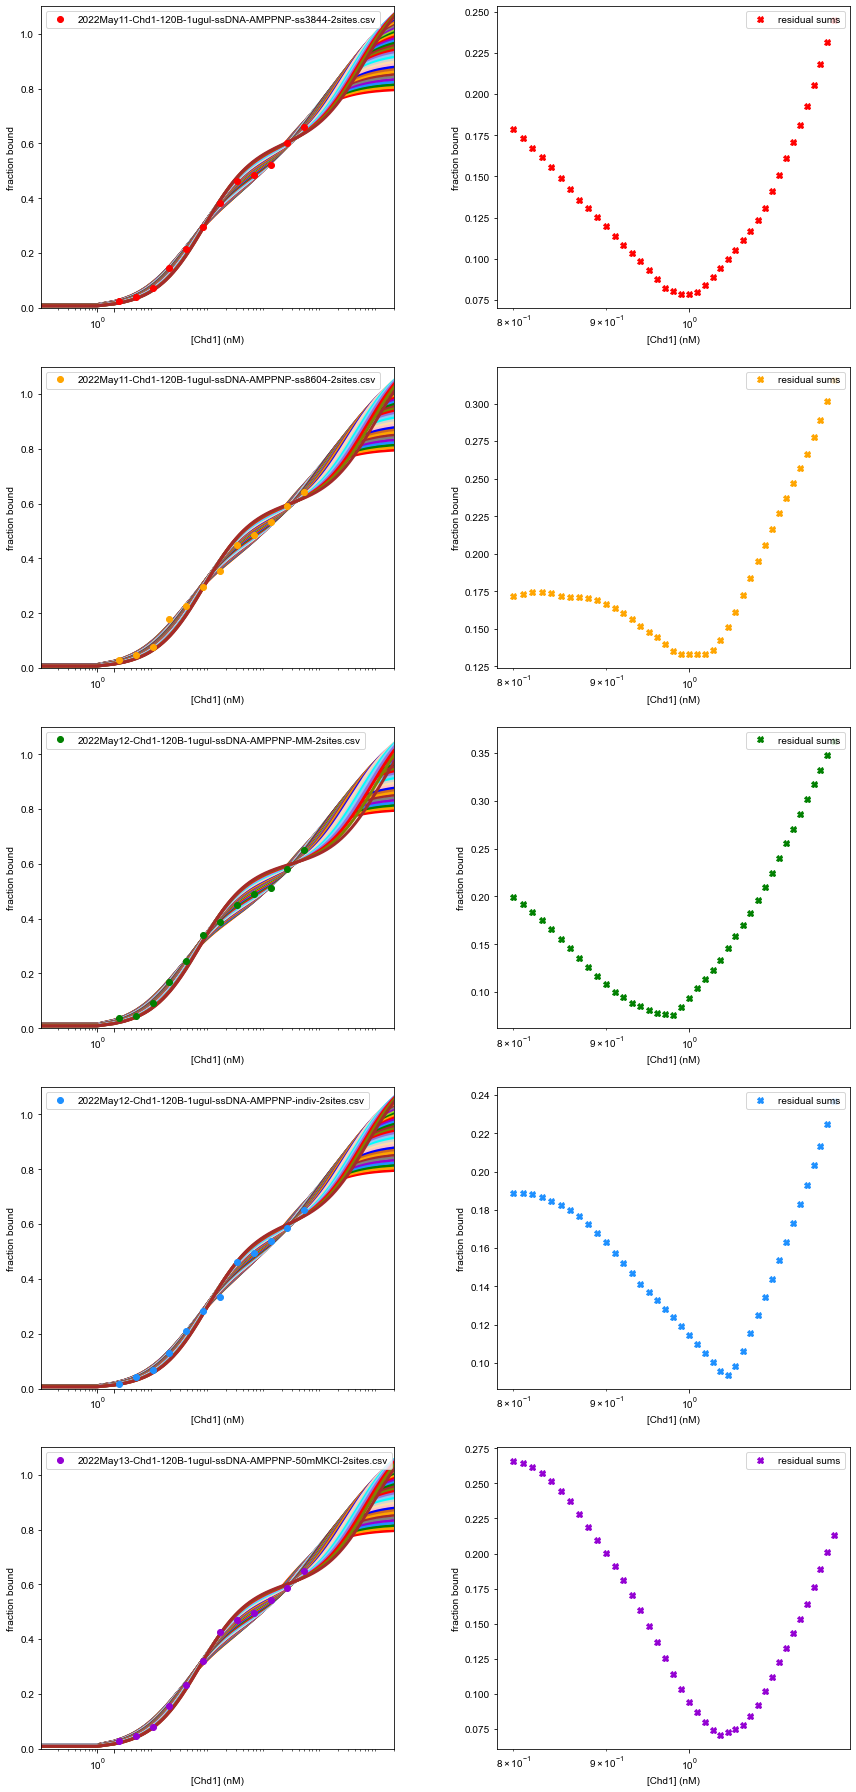

In [56]:
### show multiple fits with different fixed amplitudes; show residuals for these amplitudes, to see if 
### there is an ideal fixed amp to use

#def plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,listnamekey,amplist,workingname):
'''plot a single individual dataset along with different fits; here trying different amplitudes
show data and fit in left plot, residuals in right plot
'''
parameterdict={}
### get or set the parameters for the plots
if 'update' not in parameterdict:
    parameterdict['update']={'font.size': 10, "axes.formatter.limits": (-4,4),'errorbar.capsize': 2}
    
if 'plotStyles1' not in parameterdict:
    parameterdict['plotStyles1']={"markersize":6,"markeredgewidth":1.0,"linewidth":3.0}

if 'plotStyles2' not in parameterdict:
    parameterdict['plotStyles2']={"markersize":12,'alpha':0.5}


folder = 0

if "figure.figsize" not in parameterdict['update']:
    parameterdict['update']["figure.figsize"]=12,5*len(masterdictionary[folder]["filekeyindices"])
mpl.rcParams.update(parameterdict['update'])

### make one plot for each datafile
fig, axs = plt.subplots(len(masterdictionary[folder]["filekeyindices"]), 2) ### data and residuals, side by side

### here assuming that each expt has a 'xvalues' list; using largest number for calculating fitting range


fitxvalues=np.arange(200000)


for i in masterdictionary[folder]["filekeyindices"]:
    
    for j in range(len(masterdictionary[folder]["fitamprangevalues"])):
        ampworking=masterdictionary[folder]["fitamprangevalues"][j]
        kd1=masterdictionary[folder][i]["fitamprange"][ampworking]["fit"][0]
        kd2=masterdictionary[folder][i]["fitamprange"][ampworking]["fit"][1]
        
        axs[i,0].plot(fitxvalues,calcKddoubleAmp(fitxvalues,kd1,kd2,ampworking),"-",color=colorlist[j],alpha=1,**parameterdict['plotStyles1'])
        #axs[i,0].plot(fitxvalues,calcKddoubleAmp(fitxvalues,kd1,kd2,ampworking),"-",label=ampworking,color=colorlist[j],alpha=0.5,**parameterdict['plotStyles1'])
    ### plot with fixed amplitude of 0.90
    fixedamp=0.93
    if fixedamp in masterdictionary[folder]["fitamprangevalues"]:
        print("YES, {} in range".format(fixedamp))
        kd1=masterdictionary[folder][i]["fitamprange"][fixedamp]["fit"][0]
        kd2=masterdictionary[folder][i]["fitamprange"][fixedamp]["fit"][1]
        axs[i,0].plot(fitxvalues,calcKddoubleAmp(fitxvalues,kd1,kd2,fixedamp),"--",label="amp = {:5.3f}".format(fixedamp),color="black",alpha=1,**parameterdict['plotStyles1'])

    else:
        print("no, fixedamp not in list")
    axs[i,0].plot(masterdictionary[folder][i]["xvalues"],masterdictionary[folder][i]["yvalues"],"o",label=masterdictionary[folder][i]["filename"],color=colorlist[i],alpha=1,**parameterdict['plotStyles1'])
    axs[i,1].plot(masterdictionary[folder]["fitamprangevalues"],masterdictionary[folder][i]["fitamprange"]["residualsumlist"],"X",label="residual sums",color=colorlist[i],alpha=1,**parameterdict['plotStyles1'])
    axs[i,0].legend(loc='upper left')
    axs[i,1].legend(loc='upper right')
    axs[i,0].set_ylim(0.0,1.1)
    axs[i,0].set_xlim(0.1,200000)
        
    #axs[i,1].set_ylim(-0.05,0.05)
    

### add this to make it a log plot
plt.semilogx()
### if a log plot, change the lower bounds for xlim and ylim below
#plt.xlim([1, 5500])
#plt.ylim([0.01, 1.1])

loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals

for ax in axs.flat:
    ax.semilogx()
    ax.set(xlabel='[Chd1] (nM)', ylabel='fraction bound')
    ax.xaxis.set_major_locator(loc)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #ax.legend(loc="lower right")
    
fig.tight_layout(h_pad=2)

#add time stamp to filename

#uncomment to save plot as a PDF
#fig.savefig(outputname,format='pdf', bbox_inches='tight')
#fig.savefig(outputname,format='pdf',dpi=300, bbox_inches='tight')

workingname=outputdirectory+"Chd1binding-varyingamplitudes-"+masterdictionary[folder]["dataname"]+gettimestamp()+".pdf"

#uncomment to save plot as a PDF
fig.savefig(workingname,format='pdf',dpi=300, bbox_inches='tight')




In [12]:
### testing plot_datafolders(inputdict,dictfolderlist,workingname,parameterdict={}):
plotthisfolder=1
plotthisexpt=0
amplistname="fitamprange"
print(masterdictionary[plotthisfolder]["fitamprangevalues"])
workingname=outputdirectory+"0-Chd1bindingADP-Amplitudetest-120Bwt-40N40"
plot_datafolders_indiv_single_plusresiduals(masterdictionary,plotthisfolder,plotthisexpt,amplistname,masterdictionary[plotthisfolder]["fitamprangevalues"],workingname)

#plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,listname,listkeys,workingname,parameterdict={}):
#NEW def plot_datafolders_indiv_single_plusresiduals(inputdict,dictfolder,exptdata,ampkeylist,workingname):


KeyError: 'fitamprangevalues'